In [20]:
!pip install pandas matplotlib seaborn odfpy openpyxl


   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   ------ -------------------------------- 41.0/250.9 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 250.9/250.9 kB 3.8 MB/s eta 0:00:00


In [21]:
# ============================
# NORMALISASI NAMA MODEL PADA FILE VALIDASI
# ============================

import pandas as pd
import re

# --- BACA FILE ---
input_path = "hasil_validasi_clean.ods"
df = pd.read_excel(input_path, sheet_name="benchmark_by_validation", engine="odf")

# --- FUNGSI NORMALISASI NAMA MODEL ---
def normalisasi_nama(model):
    # Jenis model: n/s/m
    mt = re.search(r'yolo11([nsm])', model)
    model_type = mt.group(1) if mt else None

    # Resolusi input (3–4 digit angka setelah obb)
    res = re.search(r'obb[-_](\d{3,4})', model)
    resolusi = res.group(1) if res else None

    # Platform SBC
    plat = re.search(r'(jetsonorin|khadasedge2|raspberrypi5)', model)
    platform = plat.group(1) if plat else None

    # Backend/format
    if "engine" in model.lower():
        backend = "ENGINE"
    elif "ncnn" in model.lower():
        backend = "NCNN"
    elif "rknn" in model.lower():
        backend = "RKNN"
    else:
        backend = "UNKNOWN"

    # Gabungkan jika semua elemen ada
    if model_type and resolusi and platform and backend:
        return f"yolo11{model_type}_obb_{resolusi}_{platform}_{backend}"
    else:
        return None

# --- PROSES NORMALISASI ---
df["model_baru"] = df["model"].apply(normalisasi_nama)

# --- GANTI kolom model lama dengan yang baru ---
df["model"] = df["model_baru"]
df.drop(columns=["model_baru"], inplace=True)

# --- SIMPAN HASIL ---
output_path = "hasil_validasi_terstandar.xlsx"
df.to_excel(output_path, index=False)

print("✅ File berhasil disimpan ke:", output_path)


✅ File berhasil disimpan ke: hasil_validasi_terstandar.xlsx


In [22]:
# ============================
# NORMALISASI NAMA MODEL PADA FILE PREDIKSI
# ============================

import pandas as pd
import re

# --- BACA FILE ---
input_path = "hasil_prediksi_clean.ods"
df = pd.read_excel(input_path, sheet_name="benchmark_by_predict", engine="odf")

# --- FUNGSI NORMALISASI NAMA MODEL ---
def normalisasi_nama_prediksi(model):
    # Jenis model: n/s/m
    mt = re.search(r'yolo11([nsm])', model)
    model_type = mt.group(1) if mt else None

    # Resolusi input (3–4 digit angka setelah obb)
    res = re.search(r'obb[-_](\d{3,4})', model)
    resolusi = res.group(1) if res else None

    # Platform SBC
    plat = re.search(r'(jetsonorin|khadasedge2|raspberrypi5)', model)
    platform = plat.group(1) if plat else None

    # Backend/format
    if "engine" in model.lower():
        backend = "ENGINE"
    elif "ncnn" in model.lower():
        backend = "NCNN"
    elif "rknn" in model.lower():
        backend = "RKNN"
    else:
        backend = "UNKNOWN"

    if model_type and resolusi and platform and backend:
        return f"yolo11{model_type}_obb_{resolusi}_{platform}_{backend}"
    else:
        return None

# --- PROSES NORMALISASI ---
df["model_baru"] = df["model"].apply(normalisasi_nama_prediksi)

# --- GANTI kolom model lama dengan yang baru ---
df["model"] = df["model_baru"]
df.drop(columns=["model_baru"], inplace=True)

# --- SIMPAN HASIL ---
output_path = "hasil_prediksi_terstandar.xlsx"
df.to_excel(output_path, index=False)

print("✅ File berhasil disimpan ke:", output_path)


✅ File berhasil disimpan ke: hasil_prediksi_terstandar.xlsx


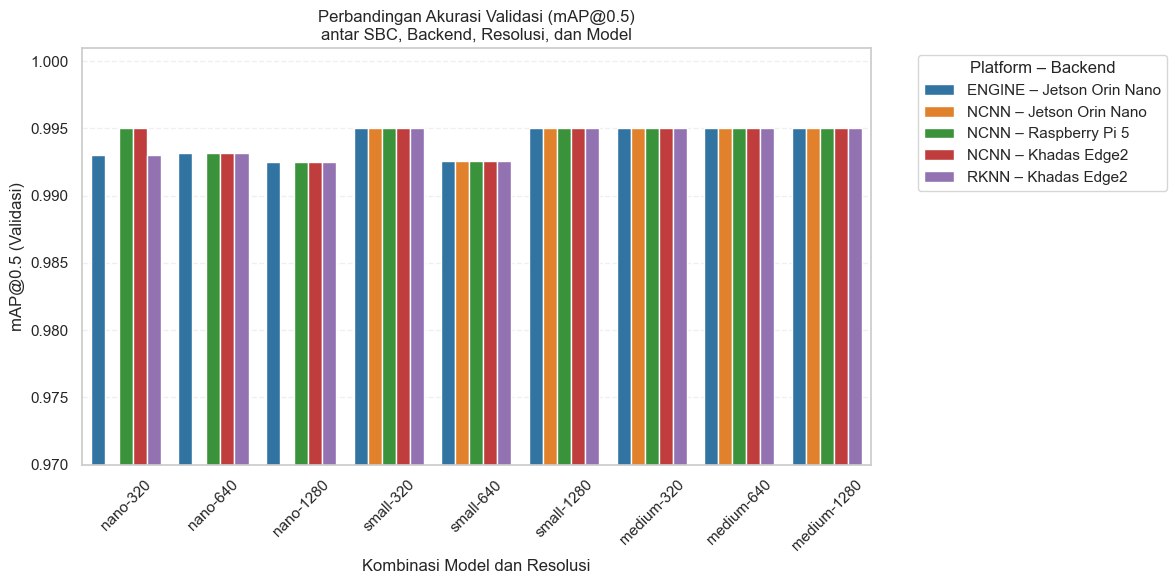

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load file validasi dan prediksi ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstraksi informasi tambahan ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]
gabung["backend_label"] = gabung["backend"] + " – " + gabung["platform"]

# --- Hapus konfigurasi error (Jetson + NCNN + nano) ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)].copy()

# --- Buat label X: model-resolusi (misal: nano-320) ---
gabung_filtered["model_config"] = gabung_filtered["model_type"] + "-" + gabung_filtered["resolusi"].astype(str)

# --- Urutan resolusi dan model untuk konsistensi sumbu X ---
ordered_models = ["nano", "small", "medium"]
ordered_res = [320, 640, 1280]
gabung_filtered["model_type"] = pd.Categorical(gabung_filtered["model_type"], categories=ordered_models, ordered=True)
gabung_filtered["resolusi"] = pd.Categorical(gabung_filtered["resolusi"], categories=ordered_res, ordered=True)

# --- Susun ulang sumbu X sesuai urutan kombinasi model-resolusi ---
gabung_filtered["model_config"] = gabung_filtered["model_type"].astype(str) + "-" + gabung_filtered["resolusi"].astype(str)
gabung_filtered["model_config"] = pd.Categorical(
    gabung_filtered["model_config"],
    categories=[
        f"{m}-{r}" for m in ordered_models for r in ordered_res
    ],
    ordered=True
)

# --- Plot bar chart mAP@0.5 ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=gabung_filtered,
    x="model_config", y="mAP50",
    hue="backend_label",
    palette="tab10",
    errorbar=None
)

plt.title("Perbandingan Akurasi Validasi (mAP@0.5)\nantar SBC, Backend, Resolusi, dan Model")
plt.xlabel("Kombinasi Model dan Resolusi")
plt.ylabel("mAP@0.5 (Validasi)")
plt.xticks(rotation=45)
plt.ylim(0.97, 1.001)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Platform – Backend", bbox_to_anchor=(1.05, 1), loc='upper left')

# Simpan gambar
plt.savefig("gambar_4_2b_akurasi_validasi.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [23]:
# ============================
# GABUNGKAN FILE VALIDASI & PREDIKSI TERSTANDAR
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- BACA FILE EXCEL YANG SUDAH DISTANDARKAN ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")

# --- GABUNGKAN BERDASARKAN KOLOM 'model' ---
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- EKSTRAK INFORMASI TAMBAHAN ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({'n': 'nano', 's': 'small', 'm': 'medium'})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0]
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0]
gabung["platform"] = gabung["platform"].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})

# --- CEK HASIL GABUNGAN ---
print("Jumlah total baris:", gabung.shape[0])
print("Distribusi per platform:\n", gabung["platform"].value_counts())


Jumlah total baris: 45
Distribusi per platform:
 platform
Jetson Orin Nano    18
Khadas Edge2        18
Raspberry Pi 5       9
Name: count, dtype: int64


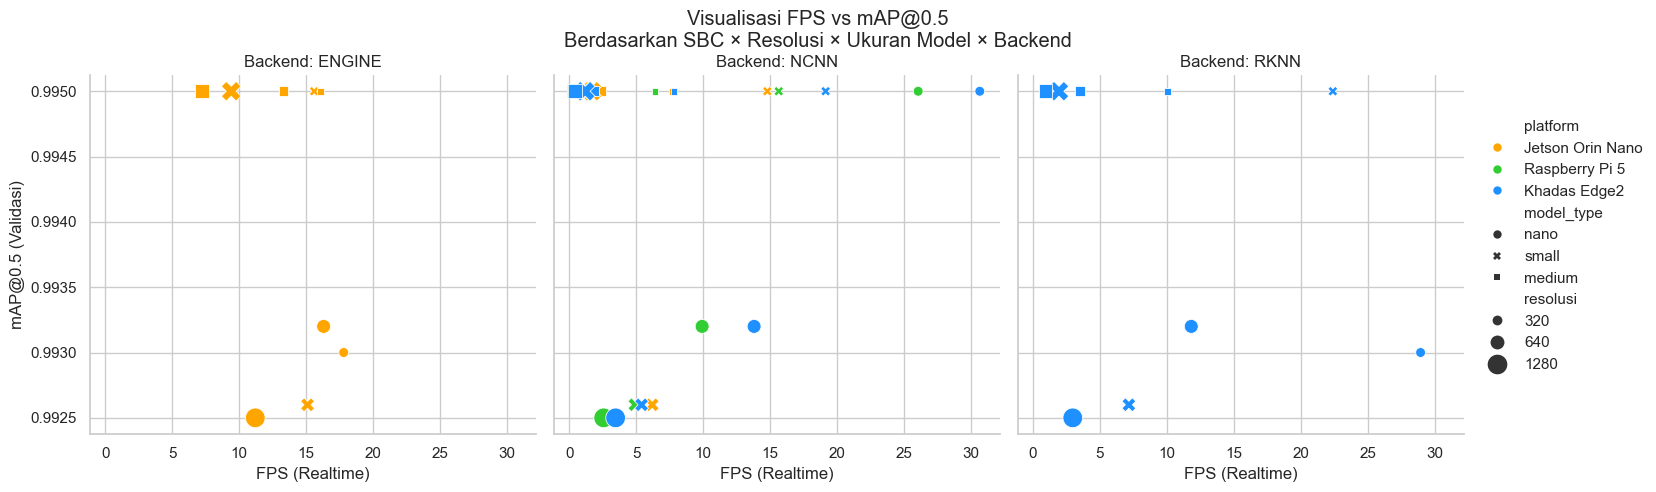

In [27]:
# ===============================
# Visualisasi FPS vs mAP@0.5 per SBC × Resolusi × Ukuran Model × Backend
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load file validasi & prediksi terstandar ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")

# --- Gabungkan berdasarkan model ---
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstraksi informasi penting ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({
    'n': 'nano', 's': 'small', 'm': 'medium'
})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]

# --- Hapus konfigurasi error: Jetson + NCNN + nano ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)]

# --- Plot relasi FPS vs mAP@0.5 per backend ---
sns.set(style="whitegrid")
g = sns.relplot(
    data=gabung_filtered,
    x="fps", y="mAP50",
    hue="platform",
    style="model_type",
    size="resolusi",
    col="backend",
    kind="scatter",
    sizes=(50, 200),
    palette={
        "Jetson Orin Nano": "#FFA500",     # oranye
        "Khadas Edge2": "#1E90FF",         # biru
        "Raspberry Pi 5": "#32CD32"        # hijau
    },
    height=5, aspect=1
)

# --- Label dan pengaturan ---
g.set_titles("Backend: {col_name}")
g.set_axis_labels("FPS (Realtime)", "mAP@0.5 (Validasi)")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Visualisasi FPS vs mAP@0.5\nBerdasarkan SBC × Resolusi × Ukuran Model × Backend")
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_27836\622170907.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gabung_filtered["label"] = gabung_filtered["model_type"] + "-" + gabung_filtered["resolusi"].astype(str)


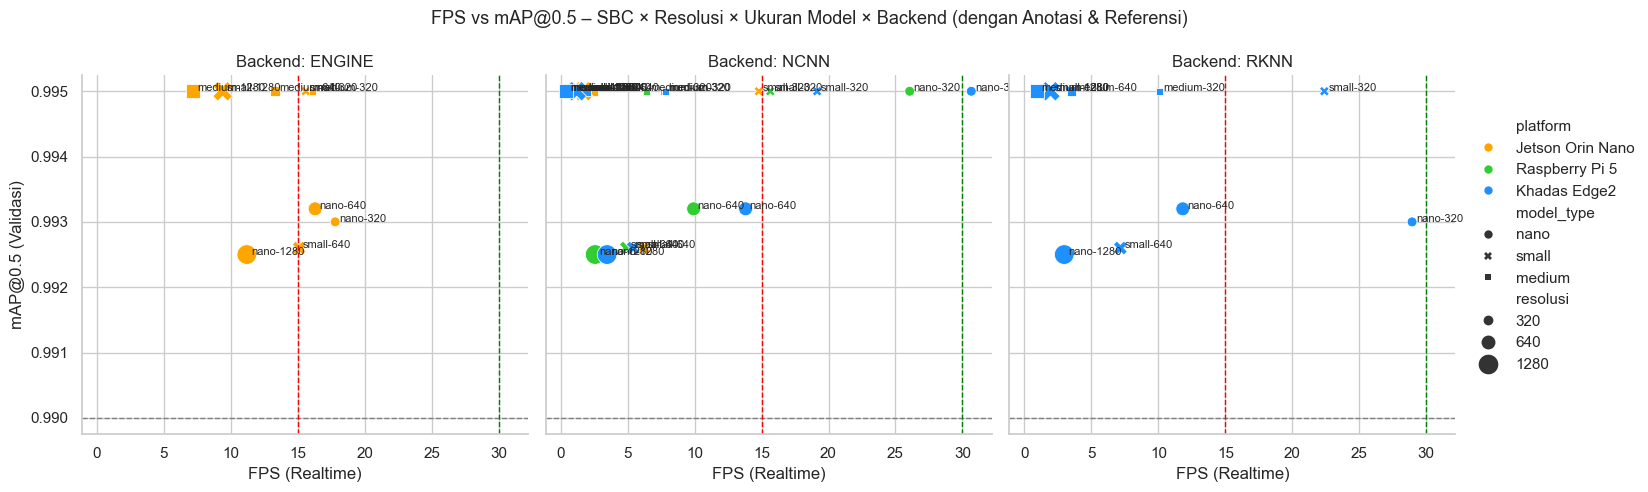

In [28]:
# ===============================
# FPS vs mAP Visualisasi + Label + Garis Referensi
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load file Excel terstandar ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")

# --- Gabungkan berdasarkan model ---
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstraksi kolom penting ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({
    'n': 'nano', 's': 'small', 'm': 'medium'
})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]

# --- Filter konfigurasi error (Jetson + NCNN + nano) ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)]

# --- Label gabungan untuk anotasi titik ---
gabung_filtered["label"] = gabung_filtered["model_type"] + "-" + gabung_filtered["resolusi"].astype(str)

# --- Buat plot per backend ---
sns.set(style="whitegrid")
g = sns.relplot(
    data=gabung_filtered,
    x="fps", y="mAP50",
    hue="platform",
    style="model_type",
    size="resolusi",
    col="backend",
    kind="scatter",
    sizes=(50, 200),
    palette={
        "Jetson Orin Nano": "#FFA500",
        "Khadas Edge2": "#1E90FF",
        "Raspberry Pi 5": "#32CD32"
    },
    height=5, aspect=1
)

# --- Tambahkan anotasi & garis referensi ---
for ax, backend in zip(g.axes.flat, g.col_names):
    subset = gabung_filtered[gabung_filtered["backend"] == backend]
    for _, row in subset.iterrows():
        ax.text(row["fps"] + 0.3, row["mAP50"], row["label"], fontsize=8)

    # Garis referensi horizontal & vertikal
    ax.axhline(0.99, color="gray", linestyle="--", linewidth=1, label="mAP@0.5=0.99")
    ax.axvline(15, color="red", linestyle="--", linewidth=1)
    ax.axvline(30, color="green", linestyle="--", linewidth=1)

# --- Format akhir ---
g.set_titles("Backend: {col_name}")
g.set_axis_labels("FPS (Realtime)", "mAP@0.5 (Validasi)")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("FPS vs mAP@0.5 – SBC × Resolusi × Ukuran Model × Backend (dengan Anotasi & Referensi)", fontsize=13)
plt.show()

# --- (Opsional) Simpan gambar sebagai file ---
#g.savefig("visualisasi_fps_vs_map.png", dpi=300)


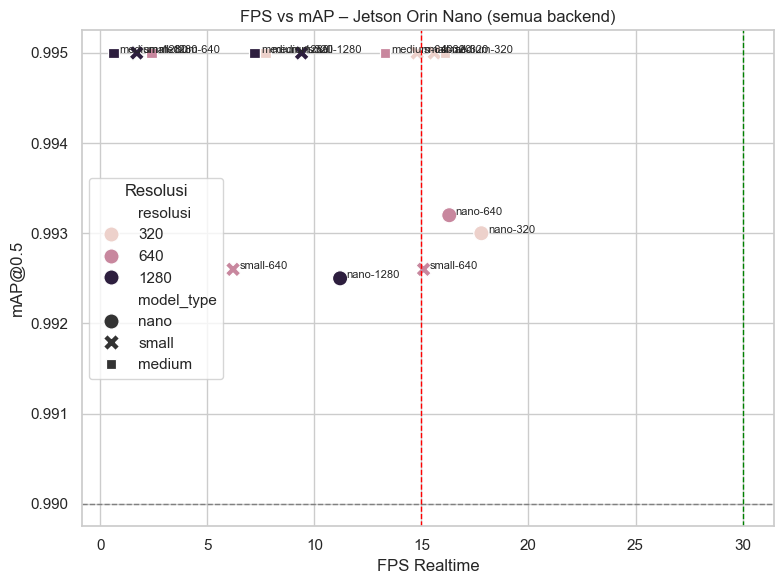

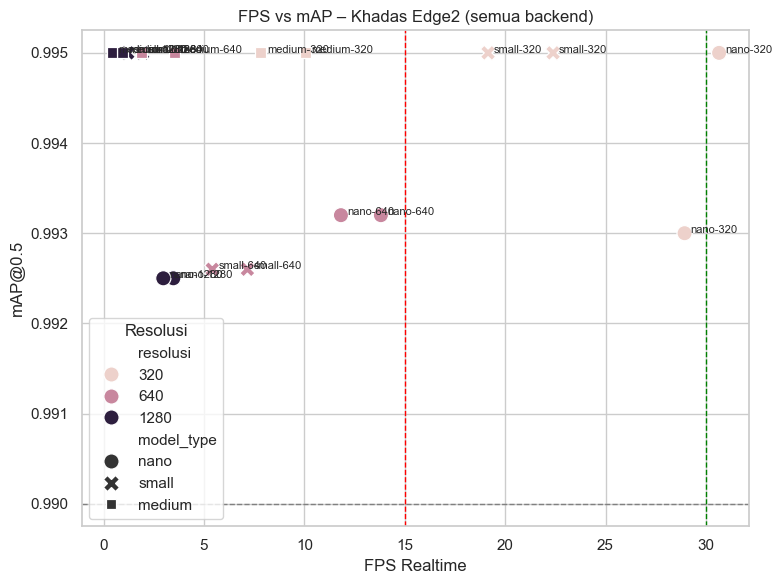

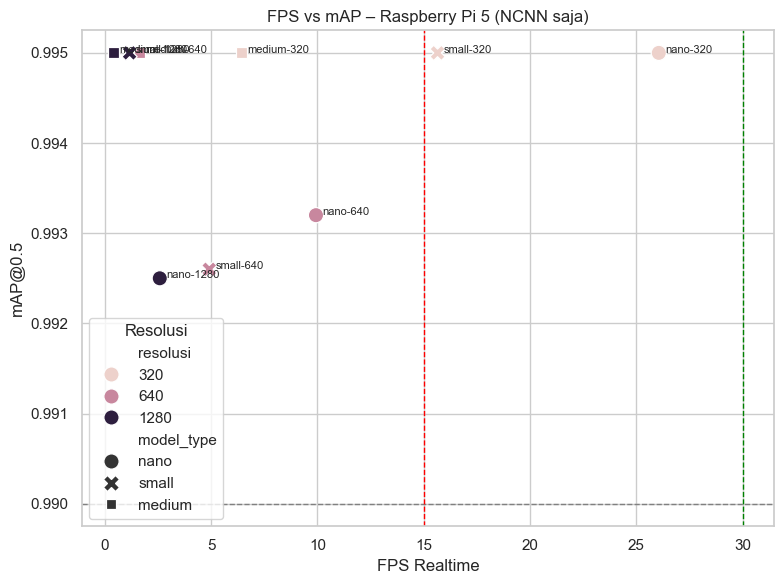

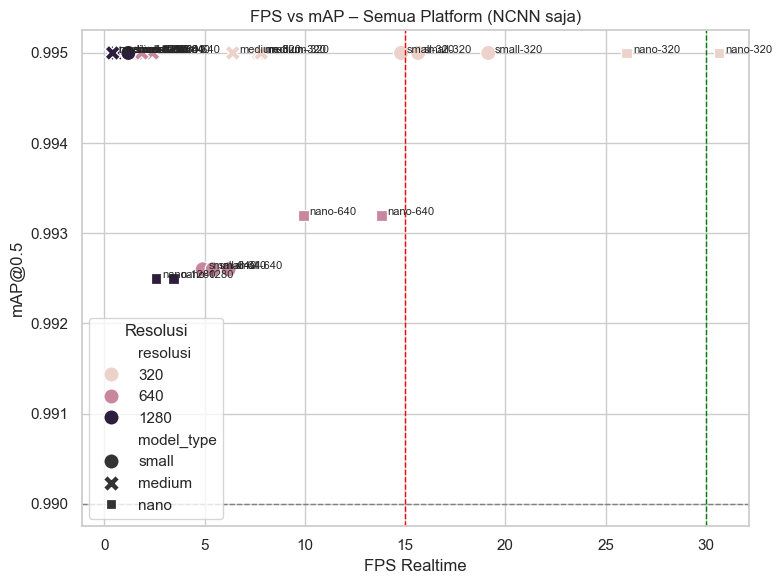

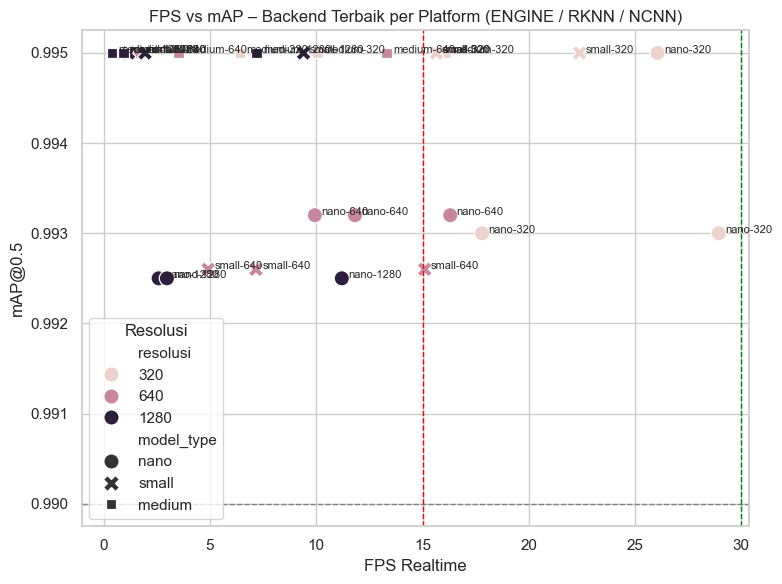

In [29]:
# ===============================
# 5 Grafik FPS vs mAP@0.5 Berdasarkan Platform & Backend
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data (jika belum dimuat) ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstrak kolom info ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({'n': 'nano', 's': 'small', 'm': 'medium'})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]

# --- Buat label kombinasi ---
gabung["label"] = gabung["model_type"] + "-" + gabung["resolusi"].astype(str)

# --- Hapus NCNN Jetson+nano (konfigurasi error) ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)]

# -----------------------------
# Fungsi plot satu grafik
# -----------------------------
def plot_fps_map(data, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data,
        x="fps", y="mAP50",
        hue="resolusi",
        style="model_type",
        s=120
    )
    for _, row in data.iterrows():
        plt.text(row["fps"]+0.3, row["mAP50"], row["label"], fontsize=8)
    plt.axhline(0.99, color="gray", linestyle="--", linewidth=1)
    plt.axvline(15, color="red", linestyle="--", linewidth=1)
    plt.axvline(30, color="green", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("FPS Realtime")
    plt.ylabel("mAP@0.5")
    plt.legend(title="Resolusi")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Grafik 1: Jetson Orin Nano (semua backend) ---
plot_fps_map(
    gabung_filtered[gabung_filtered["platform"] == "Jetson Orin Nano"],
    "FPS vs mAP – Jetson Orin Nano (semua backend)"
)

# --- Grafik 2: Khadas Edge2 ---
plot_fps_map(
    gabung_filtered[gabung_filtered["platform"] == "Khadas Edge2"],
    "FPS vs mAP – Khadas Edge2 (semua backend)"
)

# --- Grafik 3: Raspberry Pi 5 ---
plot_fps_map(
    gabung_filtered[gabung_filtered["platform"] == "Raspberry Pi 5"],
    "FPS vs mAP – Raspberry Pi 5 (NCNN saja)"
)

# --- Grafik 4: NCNN Only (semua platform) ---
plot_fps_map(
    gabung_filtered[gabung_filtered["backend"] == "NCNN"],
    "FPS vs mAP – Semua Platform (NCNN saja)"
)

# --- Grafik 5: Best Backend per Platform ---
best_backend = gabung_filtered[
    ((gabung_filtered["platform"] == "Jetson Orin Nano") & (gabung_filtered["backend"] == "ENGINE")) |
    ((gabung_filtered["platform"] == "Khadas Edge2") & (gabung_filtered["backend"] == "RKNN")) |
    ((gabung_filtered["platform"] == "Raspberry Pi 5") & (gabung_filtered["backend"] == "NCNN"))
]
plot_fps_map(
    best_backend,
    "FPS vs mAP – Backend Terbaik per Platform (ENGINE / RKNN / NCNN)"
)


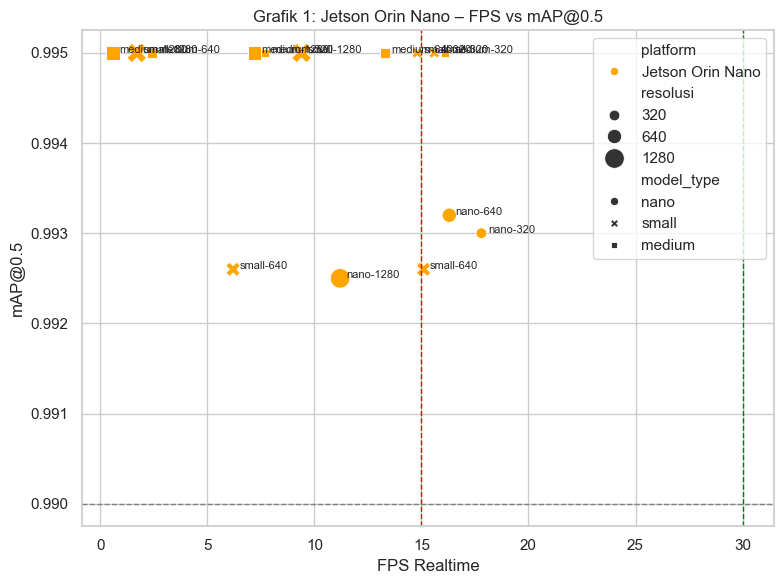

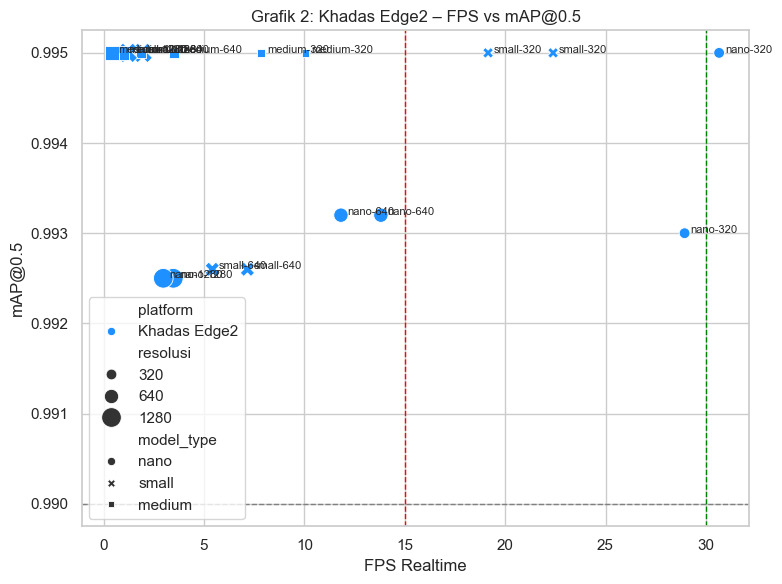

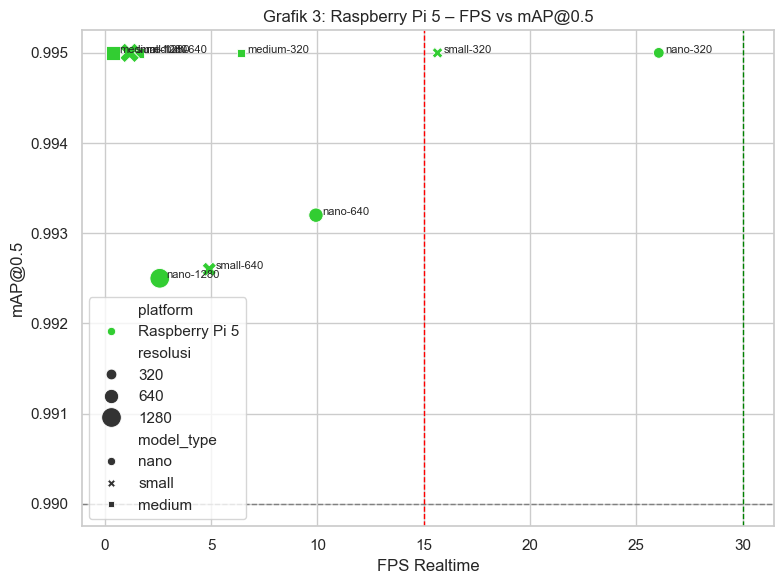

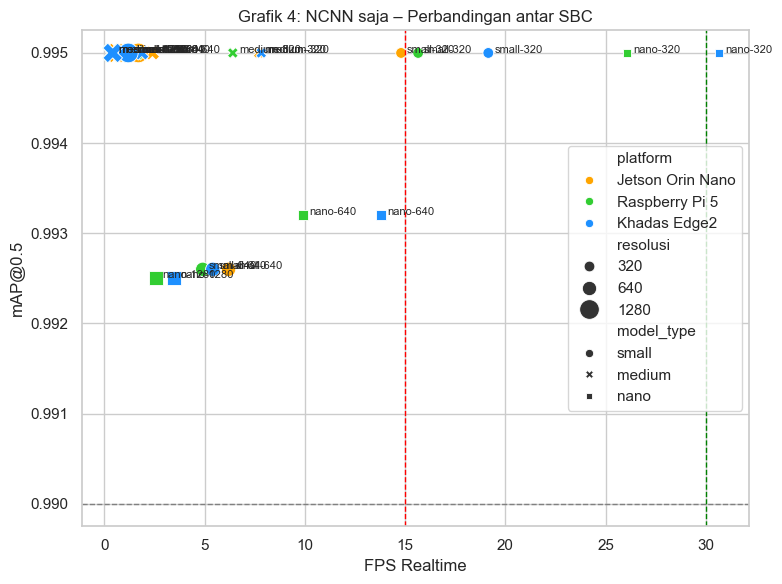

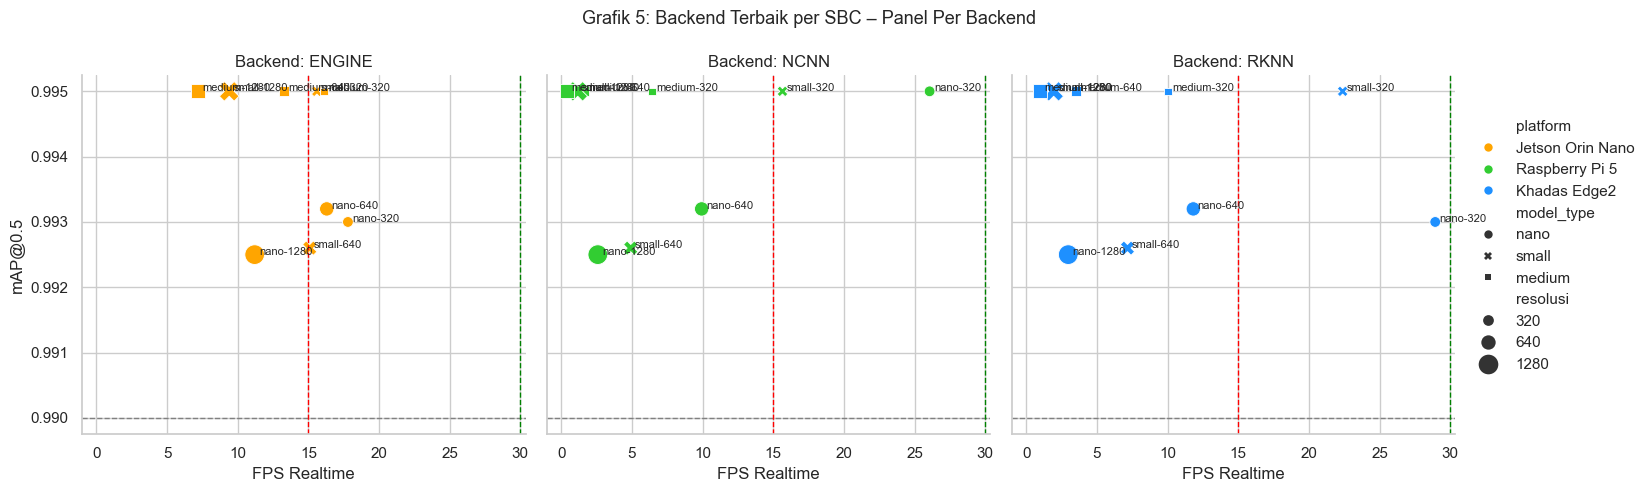

In [32]:
# ===============================
# 5 Grafik FPS vs mAP@0.5 Final (warna SBC, bentuk model, ukuran resolusi)
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstrak informasi tambahan ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({
    'n': 'nano', 's': 'small', 'm': 'medium'
})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]
gabung["label"] = gabung["model_type"] + "-" + gabung["resolusi"].astype(str)

# --- Hapus konfigurasi error: Jetson + NCNN + nano ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)]

# --- Palet warna SBC ---
palette_sbc = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# -----------------------------
# Fungsi untuk satu plot
# -----------------------------
def plot_fps_map(data, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data,
        x="fps", y="mAP50",
        hue="platform",
        style="model_type",
        size="resolusi",
        sizes=(60, 200),
        palette=palette_sbc
    )
    for _, row in data.iterrows():
        plt.text(row["fps"] + 0.3, row["mAP50"], row["label"], fontsize=8)
    plt.axhline(0.99, color="gray", linestyle="--", linewidth=1)
    plt.axvline(15, color="red", linestyle="--", linewidth=1)
    plt.axvline(30, color="green", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("FPS Realtime")
    plt.ylabel("mAP@0.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plot 1: Jetson Only
# -----------------------------
plot_fps_map(
    gabung_filtered[gabung_filtered["platform"] == "Jetson Orin Nano"],
    "Grafik 1: Jetson Orin Nano – FPS vs mAP@0.5"
)

# -----------------------------
# Plot 2: Khadas Only
# -----------------------------
plot_fps_map(
    gabung_filtered[gabung_filtered["platform"] == "Khadas Edge2"],
    "Grafik 2: Khadas Edge2 – FPS vs mAP@0.5"
)

# -----------------------------
# Plot 3: Raspberry Pi 5 Only
# -----------------------------
plot_fps_map(
    gabung_filtered[gabung_filtered["platform"] == "Raspberry Pi 5"],
    "Grafik 3: Raspberry Pi 5 – FPS vs mAP@0.5"
)

# -----------------------------
# Plot 4: NCNN Only across platforms
# -----------------------------
plot_fps_map(
    gabung_filtered[gabung_filtered["backend"] == "NCNN"],
    "Grafik 4: NCNN saja – Perbandingan antar SBC"
)

# -----------------------------
# Plot 5: Backend terbaik per platform, pakai col=backend
# -----------------------------
best_backend = gabung_filtered[
    ((gabung_filtered["platform"] == "Jetson Orin Nano") & (gabung_filtered["backend"] == "ENGINE")) |
    ((gabung_filtered["platform"] == "Khadas Edge2") & (gabung_filtered["backend"] == "RKNN")) |
    ((gabung_filtered["platform"] == "Raspberry Pi 5") & (gabung_filtered["backend"] == "NCNN"))
]

g = sns.relplot(
    data=best_backend,
    x="fps", y="mAP50",
    hue="platform",
    style="model_type",
    size="resolusi",
    col="backend",
    kind="scatter",
    sizes=(60, 200),
    palette=palette_sbc,
    height=5, aspect=1
)
for ax, backend in zip(g.axes.flat, g.col_names):
    subset = best_backend[best_backend["backend"] == backend]
    for _, row in subset.iterrows():
        ax.text(row["fps"] + 0.3, row["mAP50"], row["label"], fontsize=8)
    ax.axhline(0.99, color="gray", linestyle="--", linewidth=1)
    ax.axvline(15, color="red", linestyle="--", linewidth=1)
    ax.axvline(30, color="green", linestyle="--", linewidth=1)
g.set_titles("Backend: {col_name}")
g.set_axis_labels("FPS Realtime", "mAP@0.5")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Grafik 5: Backend Terbaik per SBC – Panel Per Backend", fontsize=13)
plt.show()


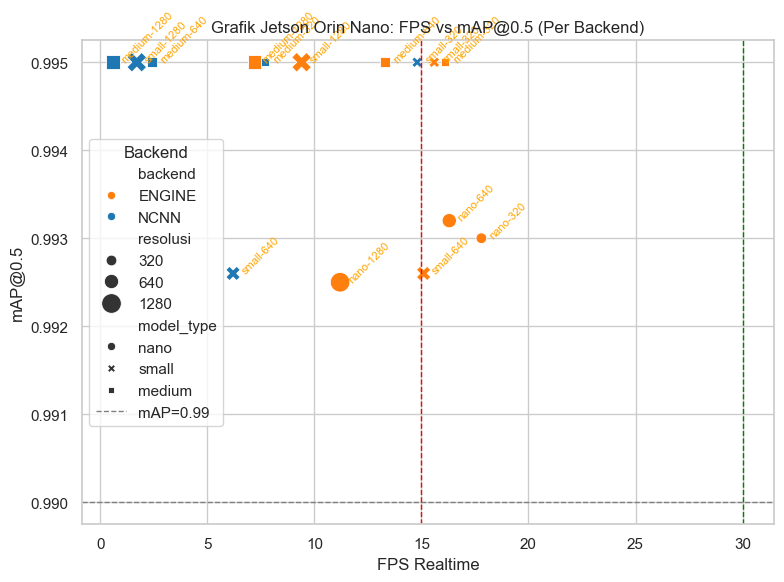

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data & persiapan kolom (jika belum) ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({'n': 'nano', 's': 'small', 'm': 'medium'})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]
gabung["label"] = gabung["model_type"] + "-" + gabung["resolusi"].astype(str)

# --- Filter Jetson Only (tanpa konfigurasi error) ---
df_jetson = gabung[
    (gabung["platform"] == "Jetson Orin Nano") &
    ~((gabung["model_type"] == "nano") & (gabung["backend"] == "NCNN"))
]

# --- Warna platform (SBC) ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Warna backend (hue visual) ---
palette_backend = {
    "ENGINE": "#FF7F0E",
    "NCNN": "#1F77B4",
    "RKNN": "#2CA02C"
}

# --- Plot dengan hue backend, label miring, berwarna sesuai platform ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_jetson,
    x="fps", y="mAP50",
    hue="backend",
    style="model_type",
    size="resolusi",
    sizes=(60, 200),
    palette=palette_backend,
)

# Tambahkan label teks dengan warna sesuai platform dan rotasi 45°
for _, row in df_jetson.iterrows():
    warna = palette_platform.get(row["platform"], "black")
    plt.text(row["fps"] + 0.3, row["mAP50"], row["label"],
             fontsize=8, rotation=45, color=warna)

# Garis referensi
plt.axhline(0.99, color="gray", linestyle="--", linewidth=1, label="mAP=0.99")
plt.axvline(15, color="red", linestyle="--", linewidth=1)
plt.axvline(30, color="green", linestyle="--", linewidth=1)

# Judul dan label
plt.title("Grafik Jetson Orin Nano: FPS vs mAP@0.5 (Per Backend)")
plt.xlabel("FPS Realtime")
plt.ylabel("mAP@0.5")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Backend")
plt.show()


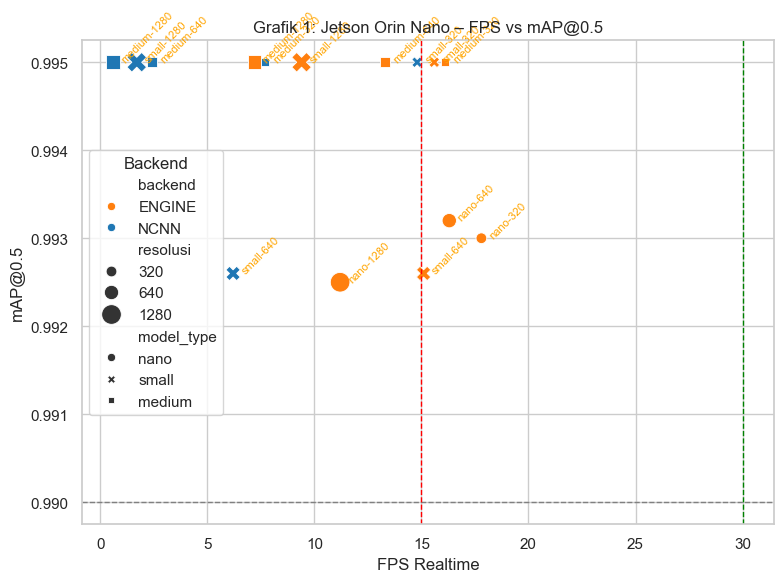

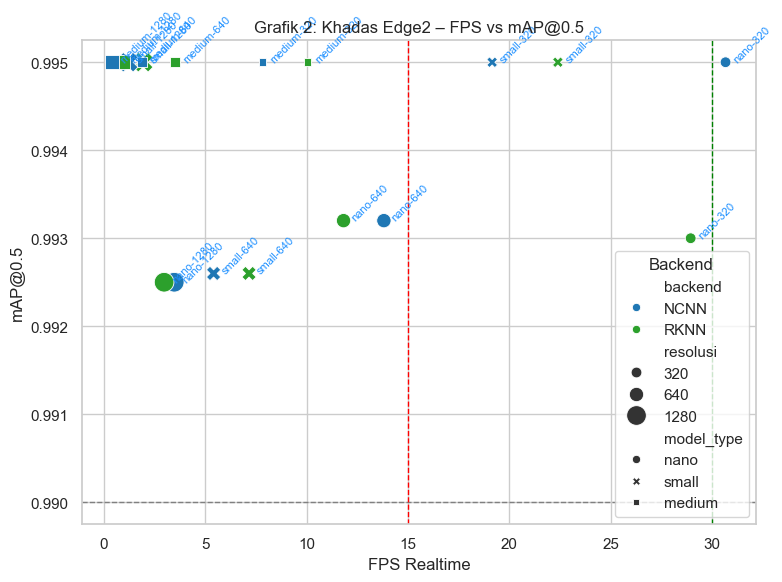

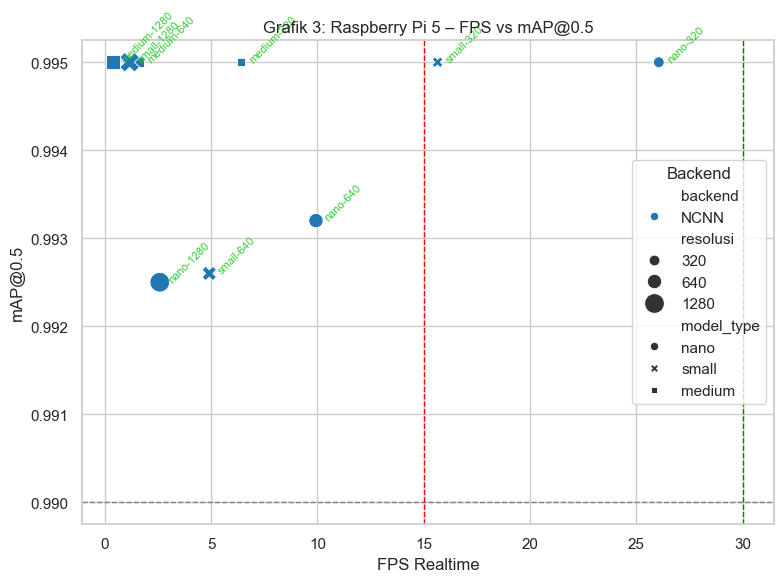

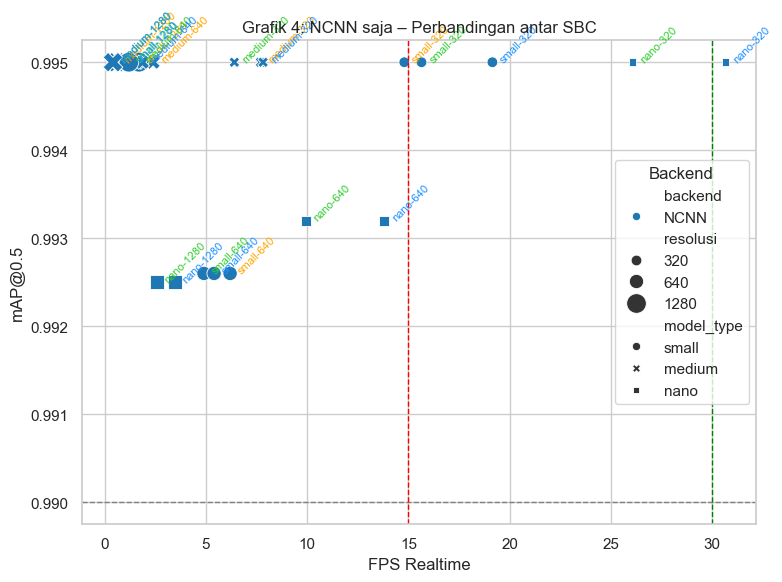

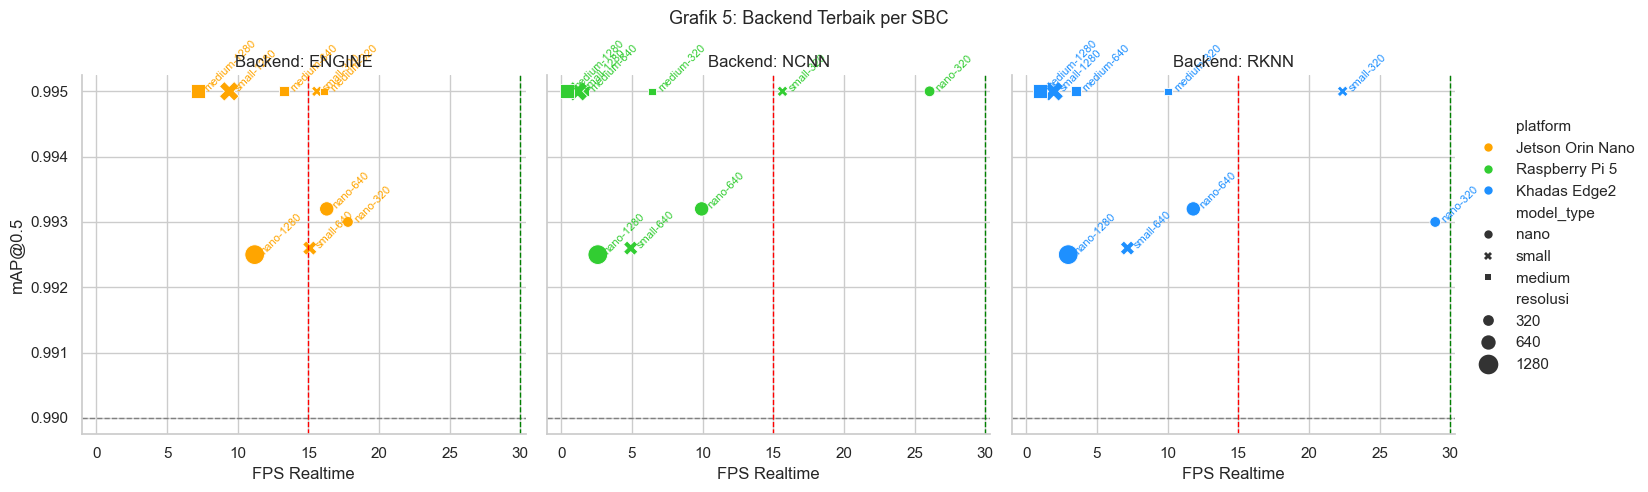

In [34]:
# ===============================
# Visualisasi 5 Grafik FPS vs mAP@0.5
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstrak kolom penting ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({'n': 'nano', 's': 'small', 'm': 'medium'})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]
gabung["label"] = gabung["model_type"] + "-" + gabung["resolusi"].astype(str)

# --- Hapus konfigurasi error Jetson + NCNN + nano ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)]

# --- Palet warna platform & backend ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}
palette_backend = {
    "ENGINE": "#FF7F0E",
    "NCNN": "#1F77B4",
    "RKNN": "#2CA02C"
}

# --- Fungsi untuk satu grafik per platform ---
def plot_per_platform(data, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data,
        x="fps", y="mAP50",
        hue="backend",
        style="model_type",
        size="resolusi",
        sizes=(60, 200),
        palette=palette_backend
    )
    for _, row in data.iterrows():
        warna = palette_platform.get(row["platform"], "black")
        plt.text(row["fps"] + 0.3, row["mAP50"], row["label"],
                 fontsize=8, rotation=45, color=warna)
    plt.axhline(0.99, color="gray", linestyle="--", linewidth=1)
    plt.axvline(15, color="red", linestyle="--", linewidth=1)
    plt.axvline(30, color="green", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("FPS Realtime")
    plt.ylabel("mAP@0.5")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title="Backend")
    plt.show()

# --- Plot 1: Jetson Orin Nano ---
plot_per_platform(
    gabung_filtered[gabung_filtered["platform"] == "Jetson Orin Nano"],
    "Grafik 1: Jetson Orin Nano – FPS vs mAP@0.5"
)

# --- Plot 2: Khadas Edge2 ---
plot_per_platform(
    gabung_filtered[gabung_filtered["platform"] == "Khadas Edge2"],
    "Grafik 2: Khadas Edge2 – FPS vs mAP@0.5"
)

# --- Plot 3: Raspberry Pi 5 ---
plot_per_platform(
    gabung_filtered[gabung_filtered["platform"] == "Raspberry Pi 5"],
    "Grafik 3: Raspberry Pi 5 – FPS vs mAP@0.5"
)

# --- Plot 4: NCNN Only (semua platform) ---
plot_per_platform(
    gabung_filtered[gabung_filtered["backend"] == "NCNN"],
    "Grafik 4: NCNN saja – Perbandingan antar SBC"
)

# --- Plot 5: Backend terbaik per SBC (col per backend) ---
best_backend = gabung_filtered[
    ((gabung_filtered["platform"] == "Jetson Orin Nano") & (gabung_filtered["backend"] == "ENGINE")) |
    ((gabung_filtered["platform"] == "Khadas Edge2") & (gabung_filtered["backend"] == "RKNN")) |
    ((gabung_filtered["platform"] == "Raspberry Pi 5") & (gabung_filtered["backend"] == "NCNN"))
]

g = sns.relplot(
    data=best_backend,
    x="fps", y="mAP50",
    hue="platform",
    style="model_type",
    size="resolusi",
    col="backend",
    kind="scatter",
    sizes=(60, 200),
    palette=palette_platform,
    height=5, aspect=1
)
for ax, backend in zip(g.axes.flat, g.col_names):
    subset = best_backend[best_backend["backend"] == backend]
    for _, row in subset.iterrows():
        warna = palette_platform.get(row["platform"], "black")
        ax.text(row["fps"] + 0.3, row["mAP50"], row["label"],
                fontsize=8, rotation=45, color=warna)
    ax.axhline(0.99, color="gray", linestyle="--", linewidth=1)
    ax.axvline(15, color="red", linestyle="--", linewidth=1)
    ax.axvline(30, color="green", linestyle="--", linewidth=1)
g.set_titles("Backend: {col_name}")
g.set_axis_labels("FPS Realtime", "mAP@0.5")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Grafik 5: Backend Terbaik per SBC", fontsize=13)
plt.show()


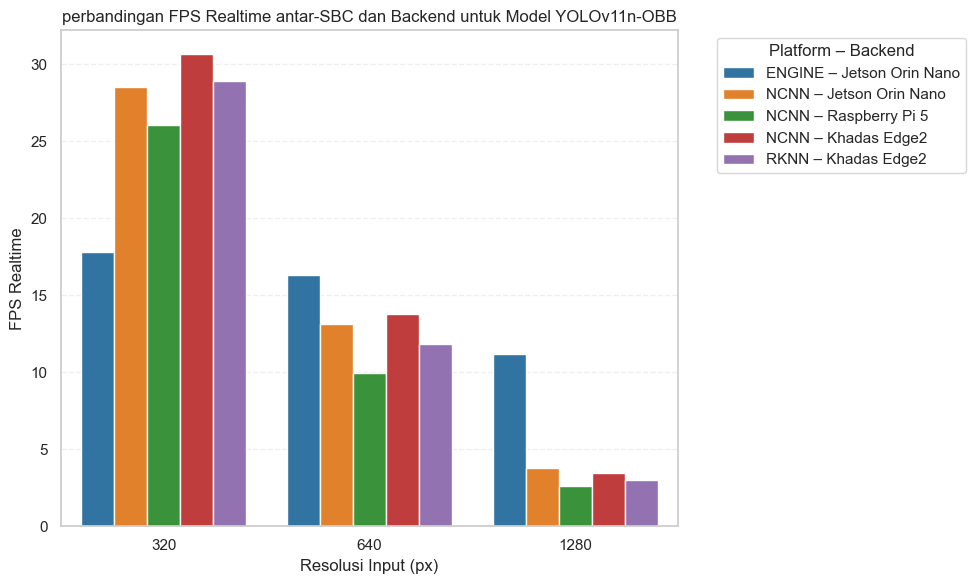

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Baca data terstandar ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstrak kolom informasi ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0]
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]

# --- Filter khusus untuk model YOLOv11n-OBB ---
df_nano = gabung[gabung["model_type"] == 'n'].copy()

# --- Label kategori backend untuk visual ---
df_nano["backend_label"] = df_nano["backend"] + " – " + df_nano["platform"]

# --- Palet warna per platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Urutan kategori (optional) ---
df_nano["resolusi"] = pd.Categorical(df_nano["resolusi"], categories=[320, 640, 1280], ordered=True)
df_nano["platform"] = pd.Categorical(df_nano["platform"], categories=["Jetson Orin Nano", "Khadas Edge2", "Raspberry Pi 5"], ordered=True)

# --- Plot bar chart ---
# --- Bar Chart FPS per Resolusi, per Platform-Backend ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_nano,
    x="resolusi", y="fps",
    hue="backend_label",
    palette="tab10",
    errorbar=None
)

plt.title("perbandingan FPS Realtime antar-SBC dan Backend untuk Model YOLOv11n-OBB")
plt.xlabel("Resolusi Input (px)")
plt.ylabel("FPS Realtime")
plt.legend(title="Platform – Backend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis="y", linestyle="--", alpha=0.3)

# Simpan gambar
plt.savefig("gambar_4_2_fps_per_platform_backend.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

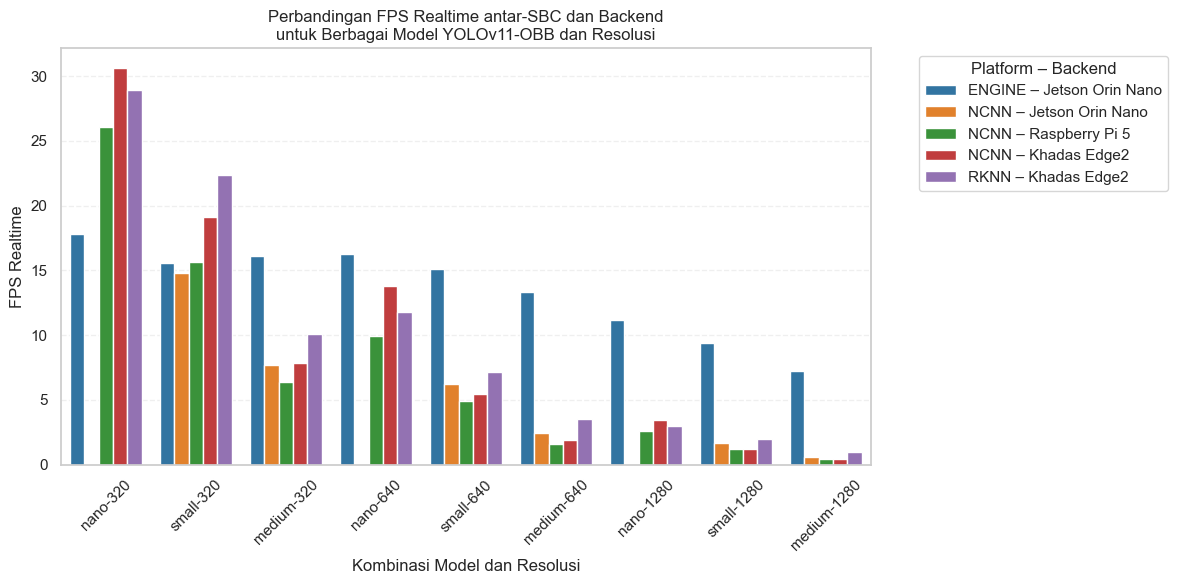

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstrak kolom informasi ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]
gabung["backend_label"] = gabung["backend"] + " – " + gabung["platform"]

# --- Filter: hapus Jetson + NCNN + nano (error runtime) ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)].copy()

# --- Buat label kombinasi model+resolusi untuk sumbu X ---
gabung_filtered["model_config"] = gabung_filtered["model_type"] + "-" + gabung_filtered["resolusi"].astype(str)

# --- Plot bar chart ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=gabung_filtered,
    x="model_config", y="fps",
    hue="backend_label",
    palette="tab10",
    errorbar=None
)

plt.title("Perbandingan FPS Realtime antar-SBC dan Backend\nuntuk Berbagai Model YOLOv11-OBB dan Resolusi")
plt.xlabel("Kombinasi Model dan Resolusi")
plt.ylabel("FPS Realtime")
plt.xticks(rotation=45)
plt.legend(title="Platform – Backend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis="y", linestyle="--", alpha=0.3)

# Simpan gambar
plt.savefig("gambar_4_2_fps_semua_model.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


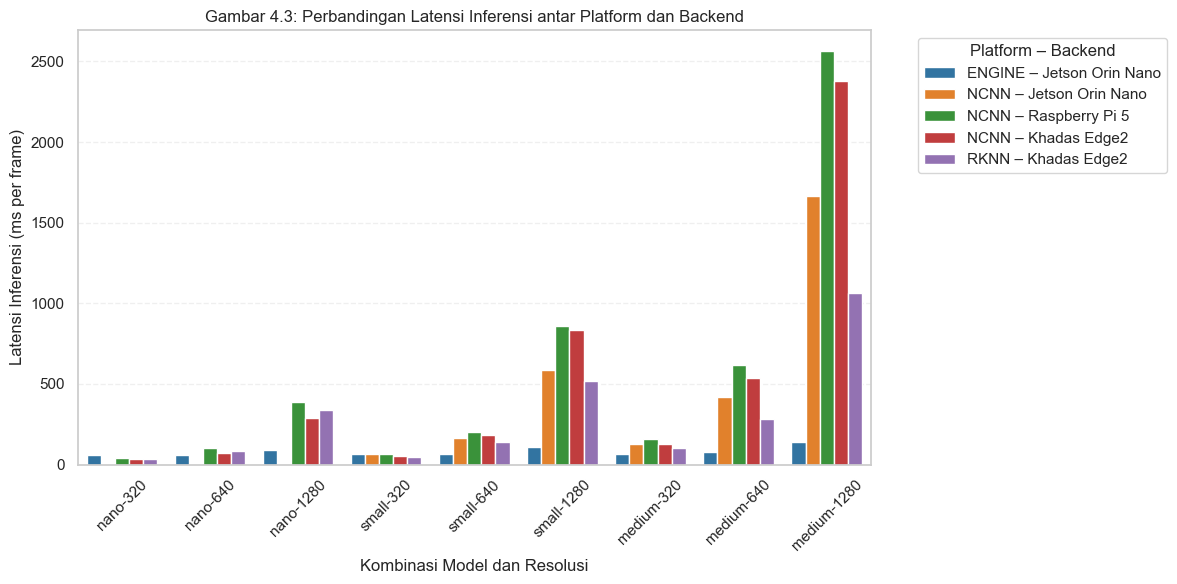

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
val_df = pd.read_excel("hasil_validasi_terstandar.xlsx")
pred_df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
gabung = pd.merge(pred_df, val_df, on="model", suffixes=("_pred", "_val"))

# --- Ekstrak dan siapkan data ---
gabung["model_type"] = gabung["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
gabung["resolusi"] = gabung["model"].str.extract(r'obb_(\d{3,4})')[0].astype(int)
gabung["platform"] = gabung["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
gabung["backend"] = gabung["model"].str.extract(r'_(ENGINE|NCNN|RKNN)$')[0]
gabung["backend_label"] = gabung["backend"] + " – " + gabung["platform"]

# --- Hapus konfigurasi error (Jetson + NCNN + nano) ---
gabung_filtered = gabung[~(
    (gabung["platform"] == "Jetson Orin Nano") &
    (gabung["model_type"] == "nano") &
    (gabung["backend"] == "NCNN")
)].copy()

# --- Hitung latensi (ms) dari FPS ---
gabung_filtered["latency_ms"] = 1000 / gabung_filtered["fps"]

# --- Buat label konfigurasi untuk X axis ---
gabung_filtered["model_config"] = gabung_filtered["model_type"] + "-" + gabung_filtered["resolusi"].astype(str)

# --- Urutkan sumbu X ---
ordered_models = ["nano", "small", "medium"]
ordered_res = [320, 640, 1280]
gabung_filtered["model_type"] = pd.Categorical(gabung_filtered["model_type"], categories=ordered_models, ordered=True)
gabung_filtered["resolusi"] = pd.Categorical(gabung_filtered["resolusi"], categories=ordered_res, ordered=True)
gabung_filtered["model_config"] = pd.Categorical(
    gabung_filtered["model_config"],
    categories=[f"{m}-{r}" for m in ordered_models for r in ordered_res],
    ordered=True
)

# --- Plot latensi per konfigurasi ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=gabung_filtered,
    x="model_config", y="latency_ms",
    hue="backend_label",
    palette="tab10",
    errorbar=None
)

plt.title("Gambar 4.3: Perbandingan Latensi Inferensi antar Platform dan Backend")
plt.xlabel("Kombinasi Model dan Resolusi")
plt.ylabel("Latensi Inferensi (ms per frame)")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Platform – Backend", bbox_to_anchor=(1.05, 1), loc='upper left')

# Simpan gambar
plt.savefig("gambar_4_3_latensi_inferensi.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


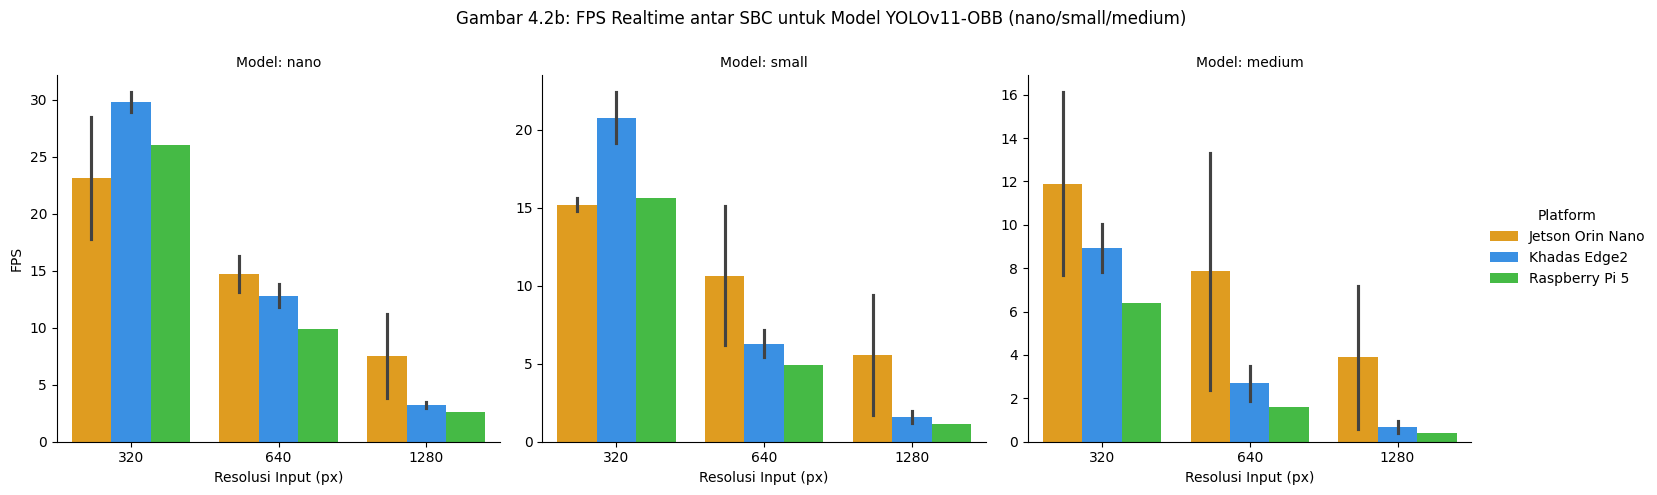

In [10]:
# ===============================
# Gambar 4.2b - FPS antar SBC untuk Semua Model (n/s/m)
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data dari ODS ---
path_prediksi = "hasil_prediksi_clean.ods"
df = pd.read_excel(path_prediksi, sheet_name="benchmark_by_predict", engine="odf")

# --- Ekstrak informasi penting ---
df["model_type"] = df["model"].str.extract(r'yolo11([nsm])[-_]')
df["resolusi"] = df["imgsz"].astype(int)
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0]
df["platform"] = df["platform"].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})

# Filter data valid
df = df.dropna(subset=["model_type", "platform"])
df["platform"] = pd.Categorical(df["platform"],
    categories=["Jetson Orin Nano", "Khadas Edge2", "Raspberry Pi 5"],
    ordered=True
)
df["resolusi"] = pd.Categorical(df["resolusi"], categories=[320, 640, 1280], ordered=True)
df["model_type"] = df["model_type"].map({'n': 'nano', 's': 'small', 'm': 'medium'})

# --- Palet warna konsisten per platform ---
palette_custom = {
    "Jetson Orin Nano": "#FFA500",    # orange
    "Khadas Edge2": "#1E90FF",        # blue
    "Raspberry Pi 5": "#32CD32"       # green
}

# --- Plot subplot untuk setiap model_type ---
g = sns.catplot(
    data=df,
    kind="bar",
    x="resolusi", y="fps", hue="platform",
    col="model_type",
    palette=palette_custom,
    height=5, aspect=1,
    sharey=False
)

g.set_titles("Model: {col_name}")
g.set_axis_labels("Resolusi Input (px)", "FPS")
g._legend.set_title("Platform")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Gambar 4.2b: FPS Realtime antar SBC untuk Model YOLOv11-OBB (nano/small/medium)")
plt.show()


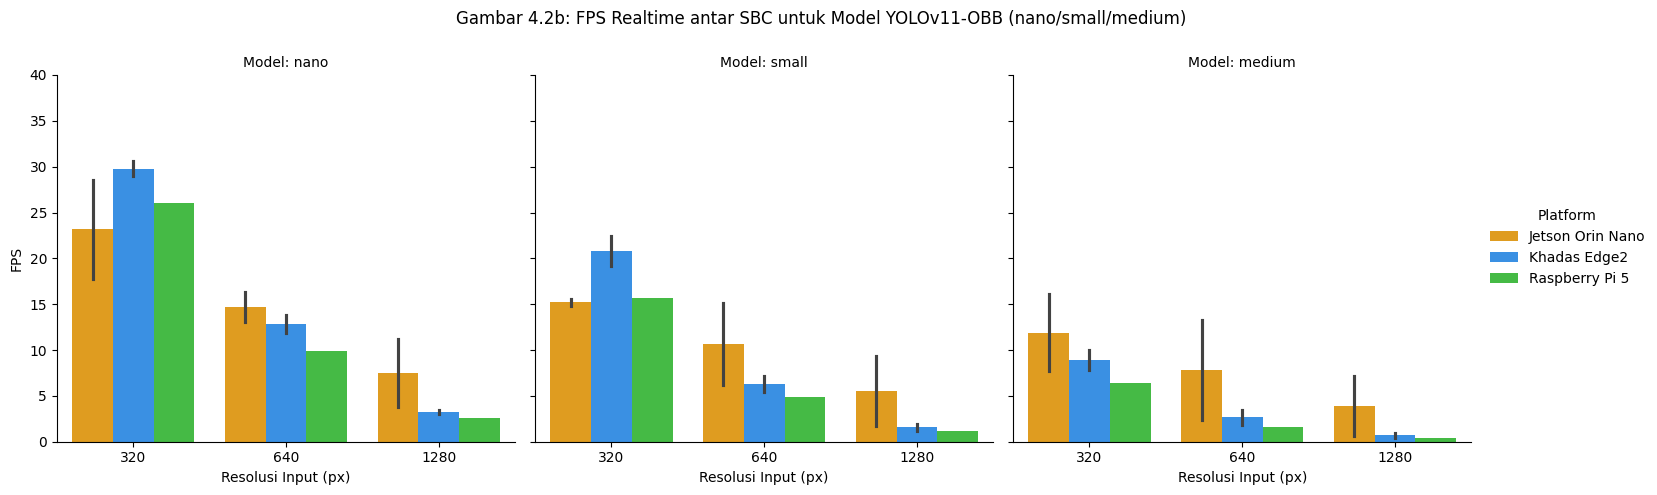

In [11]:
# ===============================
# Gambar 4.2b - FPS antar SBC untuk Semua Model (n/s/m) (Y axis uniform)
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data dari ODS ---
path_prediksi = "hasil_prediksi_clean.ods"
df = pd.read_excel(path_prediksi, sheet_name="benchmark_by_predict", engine="odf")

# --- Ekstrak informasi penting ---
df["model_type"] = df["model"].str.extract(r'yolo11([nsm])[-_]')
df["resolusi"] = df["imgsz"].astype(int)
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0]
df["platform"] = df["platform"].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})

# Filter data valid
df = df.dropna(subset=["model_type", "platform"])
df["platform"] = pd.Categorical(df["platform"],
    categories=["Jetson Orin Nano", "Khadas Edge2", "Raspberry Pi 5"],
    ordered=True
)
df["resolusi"] = pd.Categorical(df["resolusi"], categories=[320, 640, 1280], ordered=True)
df["model_type"] = df["model_type"].map({'n': 'nano', 's': 'small', 'm': 'medium'})

# --- Palet warna konsisten per platform ---
palette_custom = {
    "Jetson Orin Nano": "#FFA500",    # orange
    "Khadas Edge2": "#1E90FF",        # blue
    "Raspberry Pi 5": "#32CD32"       # green
}

# --- Plot subplot untuk setiap model_type dengan Y axis setara ---
g = sns.catplot(
    data=df,
    kind="bar",
    x="resolusi", y="fps", hue="platform",
    col="model_type",
    palette=palette_custom,
    height=5, aspect=1,
    sharey=True   # ini aktif agar subplot berbagi skala Y
)

# Set judul dan label
g.set_titles("Model: {col_name}")
g.set_axis_labels("Resolusi Input (px)", "FPS")
g._legend.set_title("Platform")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Gambar 4.2b: FPS Realtime antar SBC untuk Model YOLOv11-OBB (nano/small/medium)")

# --- Set Y-axis ke skala yang sama (maksimum 40) ---
for ax in g.axes.flat:
    ax.set_ylim(0, 40)

plt.show()


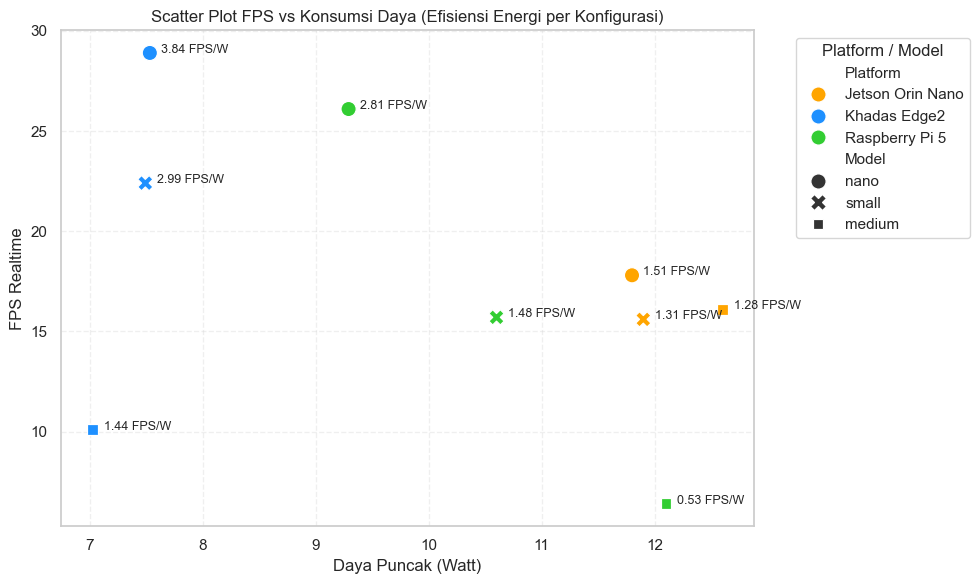

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data konsumsi daya dan FPS @320px ---
data_energi = pd.DataFrame({
    "Platform": [
        "Jetson Orin Nano", "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2", "Khadas Edge2",
        "Raspberry Pi 5", "Raspberry Pi 5", "Raspberry Pi 5"
    ],
    "Backend": [
        "TensorRT", "TensorRT", "TensorRT",
        "RKNN", "RKNN", "RKNN",
        "NCNN", "NCNN", "NCNN"
    ],
    "Model": ["nano", "small", "medium"] * 3,
    "FPS": [17.8, 15.6, 16.1, 28.9, 22.4, 10.1, 26.1, 15.7, 6.4],
    "Watt": [11.8, 11.9, 12.6, 7.53, 7.49, 7.02, 9.29, 10.6, 12.1]
})

# --- Hitung efisiensi FPS/Watt dan labelnya ---
data_energi["FPS/W"] = data_energi["FPS"] / data_energi["Watt"]
data_energi["Label"] = data_energi["Model"] + " – " + data_energi["Platform"]

# --- Warna per platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Plot Scatter ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_energi,
    x="Watt", y="FPS",
    hue="Platform",
    style="Model",
    palette=palette_platform,
    s=120
)

# Tambahkan teks label efisiensi di samping titik
for _, row in data_energi.iterrows():
    label = f"{row['FPS/W']:.2f} FPS/W"
    plt.text(row["Watt"] + 0.1, row["FPS"], label, fontsize=9)

# Judul dan sumbu
plt.title("Scatter Plot FPS vs Konsumsi Daya (Efisiensi Energi per Konfigurasi)")
plt.xlabel("Daya Puncak (Watt)")
plt.ylabel("FPS Realtime")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Platform / Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Simpan gambar
plt.savefig("gambar_4_4_efisiensi_energi.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


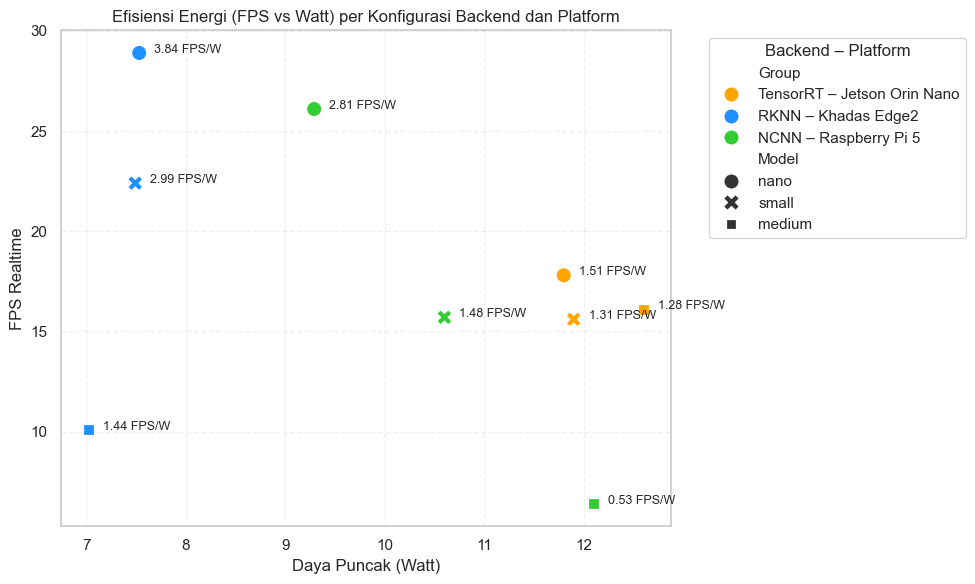

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data efisiensi energi @320px ---
data_energi = pd.DataFrame({
    "Platform": [
        "Jetson Orin Nano", "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2", "Khadas Edge2",
        "Raspberry Pi 5", "Raspberry Pi 5", "Raspberry Pi 5"
    ],
    "Backend": [
        "TensorRT", "TensorRT", "TensorRT",
        "RKNN", "RKNN", "RKNN",
        "NCNN", "NCNN", "NCNN"
    ],
    "Model": ["nano", "small", "medium"] * 3,
    "FPS": [17.8, 15.6, 16.1, 28.9, 22.4, 10.1, 26.1, 15.7, 6.4],
    "Watt": [11.8, 11.9, 12.6, 7.53, 7.49, 7.02, 9.29, 10.6, 12.1]
})

# --- Hitung efisiensi ---
data_energi["FPS/W"] = data_energi["FPS"] / data_energi["Watt"]
data_energi["Label"] = data_energi["Model"] + " – " + data_energi["Backend"]
data_energi["Group"] = data_energi["Backend"] + " – " + data_energi["Platform"]

# --- Palet warna backend + platform ---
palette_group = {
    "TensorRT – Jetson Orin Nano": "#FFA500",
    "RKNN – Khadas Edge2": "#1E90FF",
    "NCNN – Raspberry Pi 5": "#32CD32"
}

# --- Plot scatter ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_energi,
    x="Watt", y="FPS",
    hue="Group",
    style="Model",
    palette=palette_group,
    s=120
)

# --- Tambahkan label FPS/W ---
for _, row in data_energi.iterrows():
    label = f"{row['FPS/W']:.2f} FPS/W"
    plt.text(row["Watt"] + 0.15, row["FPS"], label, fontsize=9)

# --- Judul dan format ---
plt.title("Efisiensi Energi (FPS vs Watt) per Konfigurasi Backend dan Platform")
plt.xlabel("Daya Puncak (Watt)")
plt.ylabel("FPS Realtime")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Backend – Platform", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Simpan gambar ---
plt.savefig("gambar_4_4_fps_vs_watt_backend.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


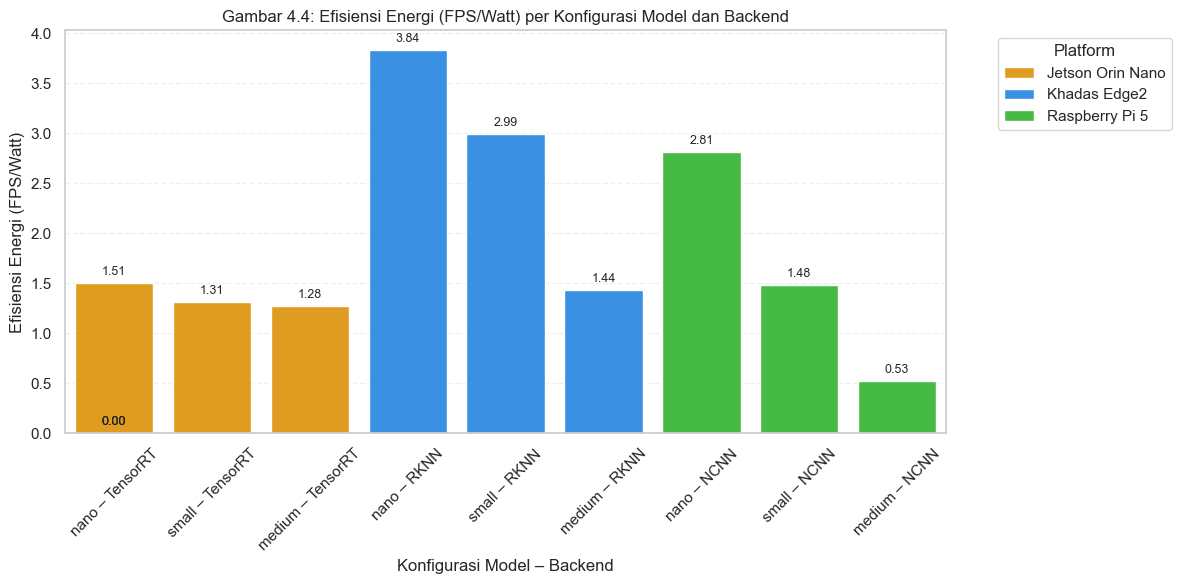

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data efisiensi energi ---
data_energi = pd.DataFrame({
    "Platform": [
        "Jetson Orin Nano", "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2", "Khadas Edge2",
        "Raspberry Pi 5", "Raspberry Pi 5", "Raspberry Pi 5"
    ],
    "Backend": [
        "TensorRT", "TensorRT", "TensorRT",
        "RKNN", "RKNN", "RKNN",
        "NCNN", "NCNN", "NCNN"
    ],
    "Model": ["nano", "small", "medium"] * 3,
    "FPS": [17.8, 15.6, 16.1, 28.9, 22.4, 10.1, 26.1, 15.7, 6.4],
    "Watt": [11.8, 11.9, 12.6, 7.53, 7.49, 7.02, 9.29, 10.6, 12.1]
})

# --- Hitung efisiensi dan label ---
data_energi["FPS/W"] = data_energi["FPS"] / data_energi["Watt"]
data_energi["Konfigurasi"] = data_energi["Model"] + " – " + data_energi["Backend"]

# --- Palet warna berdasarkan Platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Bar chart ---
plt.figure(figsize=(12, 6))
bars = sns.barplot(
    data=data_energi,
    x="Konfigurasi", y="FPS/W",
    hue="Platform",
    palette=palette_platform,
    errorbar=None
)

# Tambahkan label angka di atas bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{height:.2f}",
        ha='center', va='bottom', fontsize=9
    )

plt.title("Gambar 4.4: Efisiensi Energi (FPS/Watt) per Konfigurasi Model dan Backend")
plt.xlabel("Konfigurasi Model – Backend")
plt.ylabel("Efisiensi Energi (FPS/Watt)")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')

# Simpan ke file
plt.tight_layout()
plt.savefig("gambar_4_4_barchart_perbaikan.png", dpi=300, bbox_inches='tight')
plt.show()


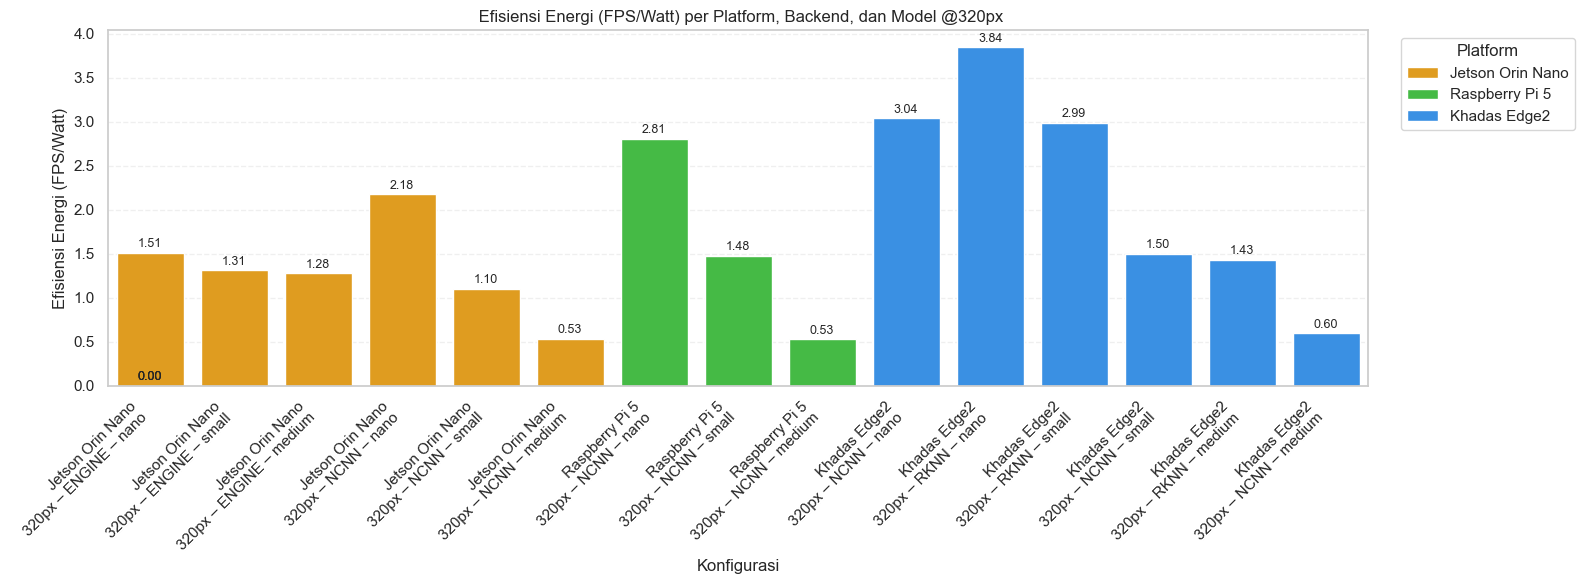

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Muat ulang data jika perlu ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")

# --- Filter resolusi 320 dan data valid ---
df = df[df["imgsz"] == 320].dropna(subset=["fps", "power"]).copy()

# --- Ekstrak informasi ---
df["model_type"] = df["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]

# --- Hitung efisiensi energi ---
df["efisiensi_fpsw"] = df["fps"] / df["power"]

# --- Buat label konfigurasi: Platform – Resolusi – Backend – Model ---
df["label_konfigurasi"] = (
    df["platform"] + "\n" + "320px – " + df["backend"] + " – " + df["model_type"]
)

# --- Palet warna platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}
df["warna"] = df["platform"].map(palette_platform)

# --- Buat bar chart ---
plt.figure(figsize=(14, 6))
bars = sns.barplot(
    data=df,
    x="label_konfigurasi", y="efisiensi_fpsw",
    hue="platform",
    dodge=False,
    palette=palette_platform,
    errorbar=None
)

# Tambahkan label angka di atas bar
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.03,
        f"{height:.2f}",
        ha='center', va='bottom', fontsize=9
    )

# Format plot
plt.title(" Efisiensi Energi (FPS/Watt) per Platform, Backend, dan Model @320px")
plt.xlabel("Konfigurasi")
plt.ylabel("Efisiensi Energi (FPS/Watt)")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc='upper left')

# Simpan
plt.savefig("gambar_4_4_barchart_eksperimen.png", dpi=300, bbox_inches='tight')
plt.show()


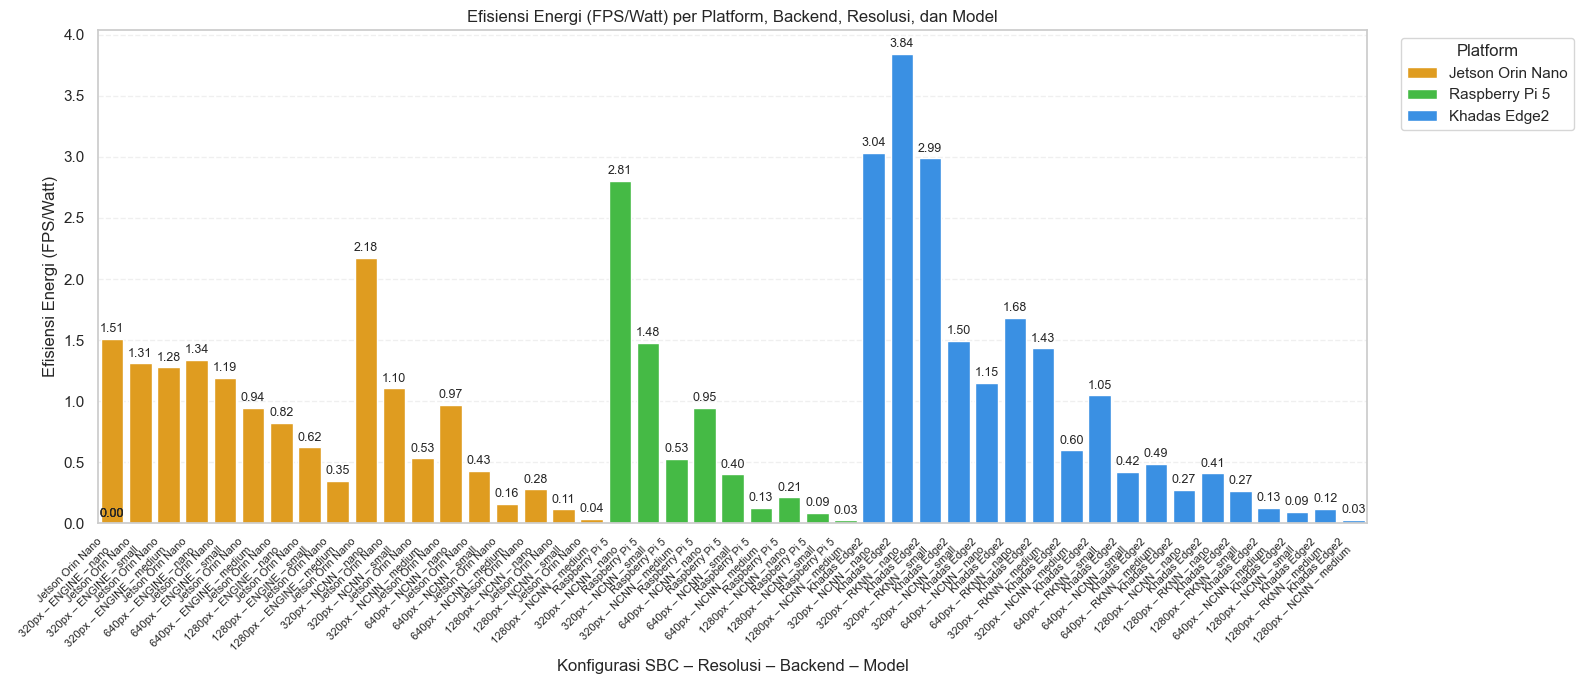

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data hasil eksperimen ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")

# --- Hapus data yang tidak lengkap (fps atau power kosong) ---
df = df.dropna(subset=["fps", "power"]).copy()

# --- Ekstrak informasi konfigurasi ---
df["model_type"] = df["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]
df["resolusi"] = df["imgsz"].astype(str) + "px"

# --- Hitung efisiensi energi ---
df["efisiensi_fpsw"] = df["fps"] / df["power"]

# --- Label konfigurasi: SBC – Resolusi – Backend – Model ---
df["label_konfigurasi"] = (
    df["platform"] + "\n" + df["resolusi"] + " – " + df["backend"] + " – " + df["model_type"]
)

# --- Warna berdasarkan platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}
df["warna"] = df["platform"].map(palette_platform)

# --- Plot bar chart ---
plt.figure(figsize=(16, 7))
bars = sns.barplot(
    data=df,
    x="label_konfigurasi", y="efisiensi_fpsw",
    hue="platform",
    dodge=False,
    palette=palette_platform,
    errorbar=None
)

# --- Label angka di atas bar ---
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.03,
        f"{height:.2f}",
        ha='center', va='bottom', fontsize=9
    )

# --- Format tampilan ---
plt.title("Efisiensi Energi (FPS/Watt) per Platform, Backend, Resolusi, dan Model")
plt.xlabel("Konfigurasi SBC – Resolusi – Backend – Model")
plt.ylabel("Efisiensi Energi (FPS/Watt)")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# --- Simpan gambar ---
plt.savefig("gambar_4_4_barchart_semua_resolusi.png", dpi=300, bbox_inches='tight')
plt.show()


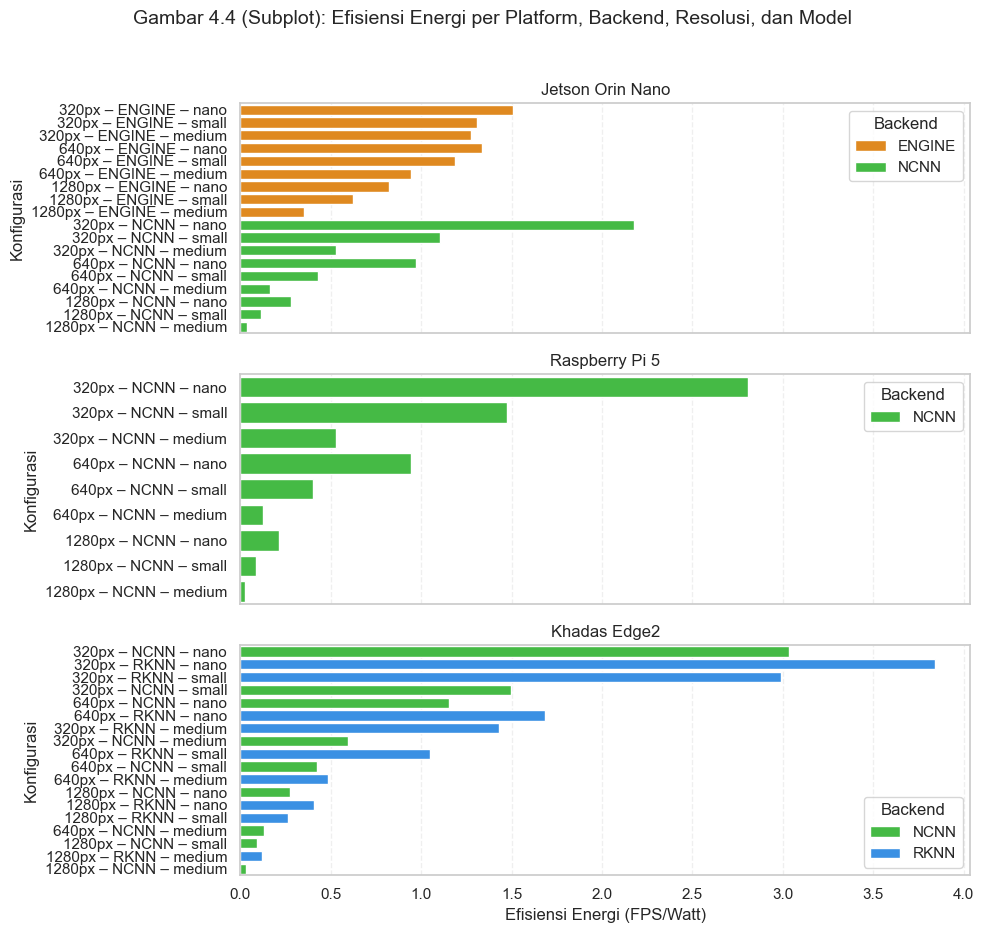

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
df = df.dropna(subset=["fps", "power"]).copy()

# --- Ekstrak informasi ---
df["model_type"] = df["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]
df["resolusi"] = df["imgsz"].astype(str) + "px"

# --- Hitung efisiensi dan label konfigurasi ---
df["efisiensi_fpsw"] = df["fps"] / df["power"]
df["label_konfig"] = df["resolusi"] + " – " + df["backend"] + " – " + df["model_type"]

# --- Warna backend (agar konsisten di semua subplot) ---
palette_backend = {
    "ENGINE": "#FF8C00",
    "RKNN": "#1E90FF",
    "NCNN": "#32CD32"
}

# --- Buat subplot per platform ---
platforms = df["platform"].unique()
n_plot = len(platforms)

fig, axes = plt.subplots(nrows=n_plot, figsize=(10, 5 + n_plot * 1.5), sharex=True)

for i, plat in enumerate(platforms):
    ax = axes[i]
    df_sub = df[df["platform"] == plat].copy()
    
    sns.barplot(
        data=df_sub,
        x="efisiensi_fpsw", y="label_konfig",
        hue="backend",
        palette=palette_backend,
        ax=ax,
        errorbar=None
    )
    
    ax.set_title(f"{plat}")
    ax.set_xlabel("Efisiensi Energi (FPS/Watt)")
    ax.set_ylabel("Konfigurasi")
    ax.legend(title="Backend")
    ax.grid(True, axis="x", linestyle="--", alpha=0.3)

plt.suptitle("Gambar 4.4 (Subplot): Efisiensi Energi per Platform, Backend, Resolusi, dan Model", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("gambar_4_4_subplot_horizontal.png", dpi=300, bbox_inches='tight')
plt.show()


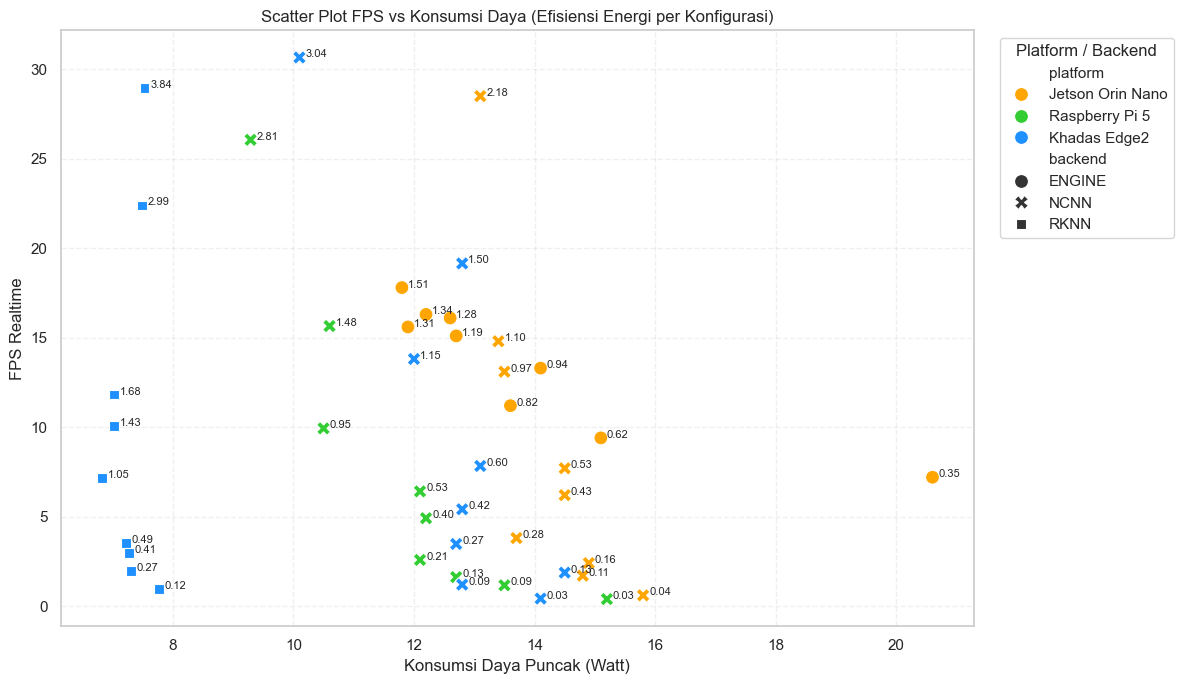

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data eksperimen ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
df = df.dropna(subset=["fps", "power"]).copy()

# --- Ekstrak informasi ---
df["model_type"] = df["model"].str.extract(r'yolo11([nsm])')[0].map({
    "n": "nano", "s": "small", "m": "medium"
})
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]
df["resolusi"] = df["imgsz"].astype(str) + "px"
df["efisiensi_fpsw"] = df["fps"] / df["power"]

# --- Label titik (misal: nano-320 RKNN) ---
df["label"] = df["model_type"] + " – " + df["resolusi"] + " – " + df["backend"]

# --- Palet warna per platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Plot scatter ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x="power", y="fps",
    hue="platform",
    style="backend",
    palette=palette_platform,
    s=100
)

# Tambahkan label efisiensi di dekat titik
for _, row in df.iterrows():
    label = f"{row['efisiensi_fpsw']:.2f}"
    plt.text(row["power"] + 0.1, row["fps"], label, fontsize=8)

plt.title("Scatter Plot FPS vs Konsumsi Daya (Efisiensi Energi per Konfigurasi)")
plt.xlabel("Konsumsi Daya Puncak (Watt)")
plt.ylabel("FPS Realtime")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Platform / Backend", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gambar_4_4_scatterplot.png", dpi=300, bbox_inches='tight')
plt.show()


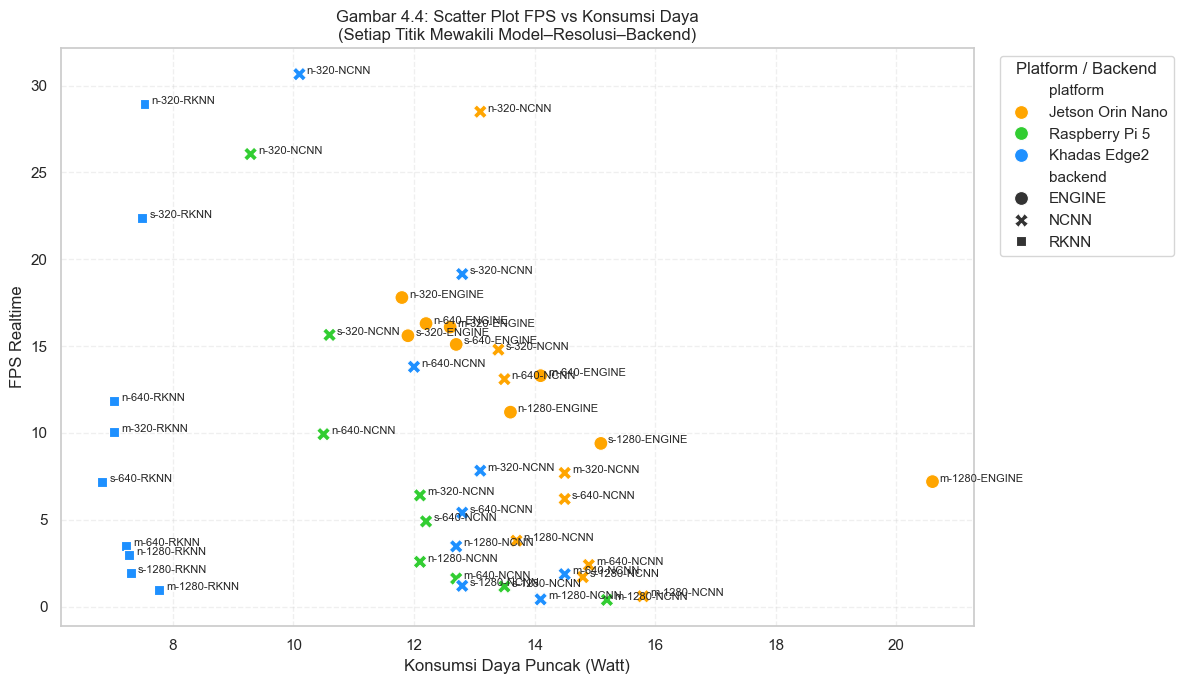

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dan siapkan data ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
df = df.dropna(subset=["fps", "power"]).copy()

# --- Ekstrak konfigurasi ---
df["model_code"] = df["model"].str.extract(r'yolo11([nsm])')[0]
df["model_type"] = df["model_code"].map({"n": "nano", "s": "small", "m": "medium"})
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]
df["resolusi"] = df["imgsz"].astype(str)

# --- Hitung efisiensi FPS/W ---
df["efisiensi_fpsw"] = df["fps"] / df["power"]

# --- Label titik: model–resolusi–backend ---
df["label"] = df["model_code"] + "-" + df["resolusi"] + "-" + df["backend"]

# --- Warna platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Plot scatter ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x="power", y="fps",
    hue="platform",
    style="backend",
    palette=palette_platform,
    s=100
)

# Tambahkan label konfigurasi: n-320-NCNN, m-1280-RKNN, dst
for _, row in df.iterrows():
    plt.text(row["power"] + 0.12, row["fps"], row["label"], fontsize=8)

plt.title("Gambar 4.4: Scatter Plot FPS vs Konsumsi Daya\n(Setiap Titik Mewakili Model–Resolusi–Backend)")
plt.xlabel("Konsumsi Daya Puncak (Watt)")
plt.ylabel("FPS Realtime")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Platform / Backend", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gambar_4_4_scatterplot_label_lengkap.png", dpi=300, bbox_inches='tight')
plt.show()


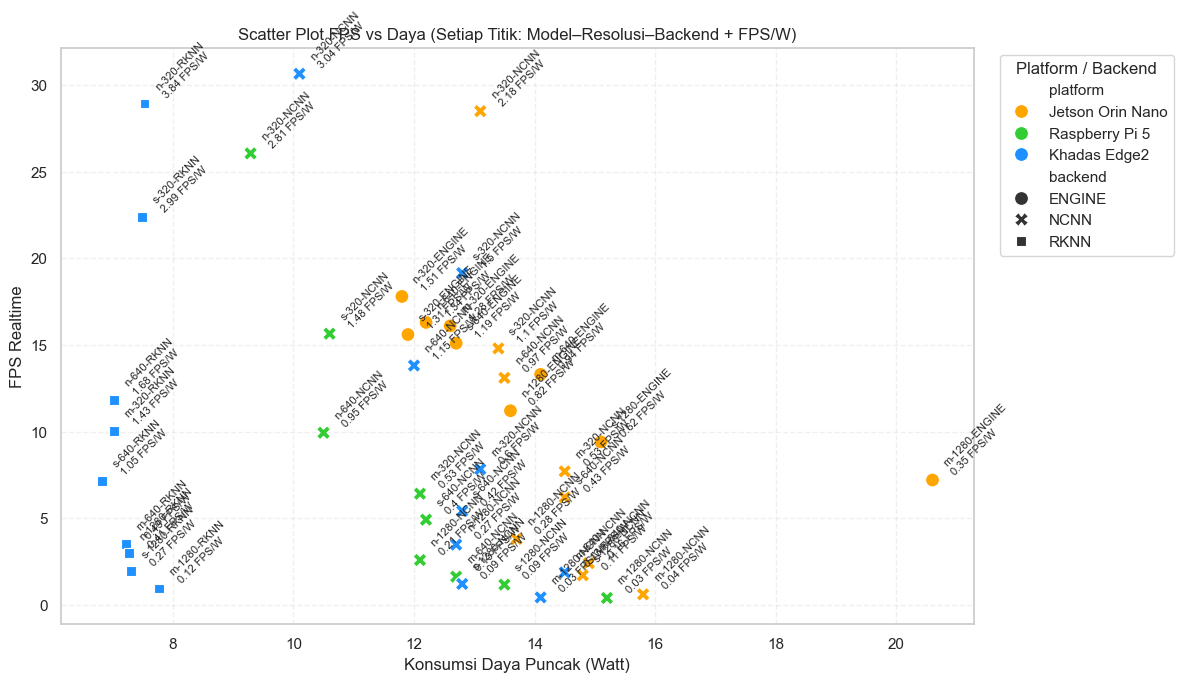

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dan siapkan data ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
df = df.dropna(subset=["fps", "power"]).copy()

# --- Ekstrak konfigurasi ---
df["model_code"] = df["model"].str.extract(r'yolo11([nsm])')[0]
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]
df["resolusi"] = df["imgsz"].astype(str)

# --- Hitung efisiensi dan label teks ---
df["efisiensi_fpsw"] = df["fps"] / df["power"]
df["label"] = (
    df["model_code"] + "-" + df["resolusi"] + "-" + df["backend"] +
    "\n" + df["efisiensi_fpsw"].round(2).astype(str) + " FPS/W"
)

# --- Warna per platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Plot scatter ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x="power", y="fps",
    hue="platform",
    style="backend",
    palette=palette_platform,
    s=100
)

# Tambahkan label miring 45° dengan FPS/Watt
for _, row in df.iterrows():
    plt.text(
        row["power"] + 0.15, row["fps"] + 0.2,
        row["label"],
        fontsize=8, rotation=45, ha='left', va='bottom'
    )

# --- Format dan simpan ---
plt.title("Scatter Plot FPS vs Daya (Setiap Titik: Model–Resolusi–Backend + FPS/W)")
plt.xlabel("Konsumsi Daya Puncak (Watt)")
plt.ylabel("FPS Realtime")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Platform / Backend", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gambar_4_4_scatterplot_final.png", dpi=300, bbox_inches='tight')
plt.show()


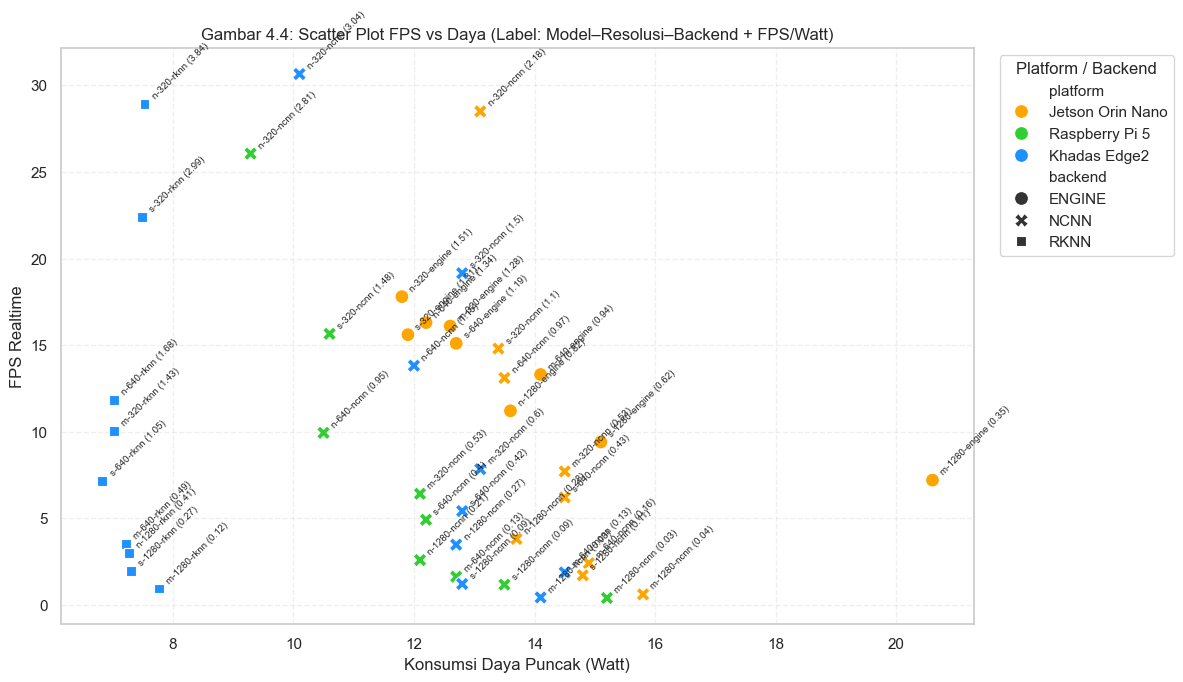

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dan siapkan data ---
df = pd.read_excel("hasil_prediksi_terstandar.xlsx")
df = df.dropna(subset=["fps", "power"]).copy()

# --- Ekstrak konfigurasi ---
df["model_code"] = df["model"].str.extract(r'yolo11([nsm])')[0]
df["platform"] = df["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
df["backend"] = df["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]
df["resolusi"] = df["imgsz"].astype(str)

# --- Hitung efisiensi dan label teks ---
df["efisiensi_fpsw"] = df["fps"] / df["power"]
df["label"] = (
    df["model_code"] + "-" + df["resolusi"] + "-" + df["backend"].str.lower() +
    " (" + df["efisiensi_fpsw"].round(2).astype(str) + ")"
)

# --- Warna per platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Plot scatter ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x="power", y="fps",
    hue="platform",
    style="backend",
    palette=palette_platform,
    s=100
)

# Tambahkan label: n-320-rknn (3.84)
for _, row in df.iterrows():
    plt.text(
        row["power"] + 0.1, row["fps"] + 0.2,
        row["label"],
        fontsize=7, rotation=45, ha='left', va='bottom'
    )

# --- Format plot ---
plt.title("Gambar 4.4: Scatter Plot FPS vs Daya (Label: Model–Resolusi–Backend + FPS/Watt)")
plt.xlabel("Konsumsi Daya Puncak (Watt)")
plt.ylabel("FPS Realtime")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Platform / Backend", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gambar_4_4_scatterplot_label_singkat.png", dpi=300, bbox_inches='tight')
plt.show()


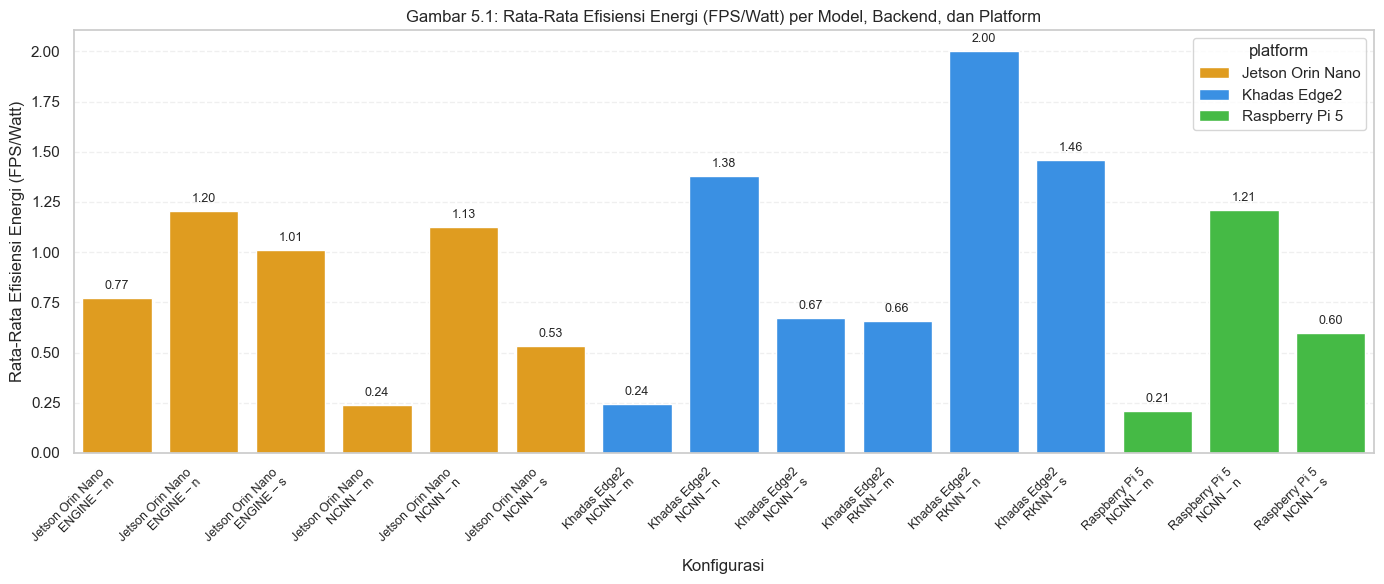

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data hasil agregasi rata-rata
rata_rata = pd.read_excel("hasil_prediksi_terstandar.xlsx")
rata_rata = rata_rata.dropna(subset=["fps", "power"]).copy()

# Ekstraksi ulang
rata_rata["model_code"] = rata_rata["model"].str.extract(r'yolo11([nsm])')[0]
rata_rata["platform"] = rata_rata["model"].str.extract(r'_(jetsonorin|khadasedge2|raspberrypi5)_')[0].replace({
    "jetsonorin": "Jetson Orin Nano",
    "khadasedge2": "Khadas Edge2",
    "raspberrypi5": "Raspberry Pi 5"
})
rata_rata["backend"] = rata_rata["model"].str.extract(r'_(ENGINE|RKNN|NCNN)$')[0]

# Hitung agregat per model_code + platform + backend
df_agg = rata_rata.groupby(["platform", "backend", "model_code"]).agg({
    "fps": "mean",
    "power": "mean"
}).reset_index()
df_agg["efisiensi_fpsw"] = df_agg["fps"] / df_agg["power"]
df_agg["konfigurasi"] = df_agg["platform"] + "\n" + df_agg["backend"] + " – " + df_agg["model_code"]

# Warna berdasarkan platform
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}
df_agg["warna"] = df_agg["platform"].map(palette_platform)

# Plot bar chart
plt.figure(figsize=(14, 6))
bars = sns.barplot(
    data=df_agg,
    x="konfigurasi", y="efisiensi_fpsw",
    hue="platform",
    palette=palette_platform,
    dodge=False,
    errorbar=None
)
# Tambahkan nilai efisiensi di atas bar
for bar, nilai in zip(bars.patches, df_agg["efisiensi_fpsw"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.03,
        f"{nilai:.2f}",
        ha='center', va='bottom', fontsize=9
    )

plt.title("Gambar 5.1: Rata-Rata Efisiensi Energi (FPS/Watt) per Model, Backend, dan Platform")
plt.xlabel("Konfigurasi")
plt.ylabel("Rata-Rata Efisiensi Energi (FPS/Watt)")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("gambar_5_1_rerata_efisiensi.png", dpi=300, bbox_inches='tight')
plt.show()


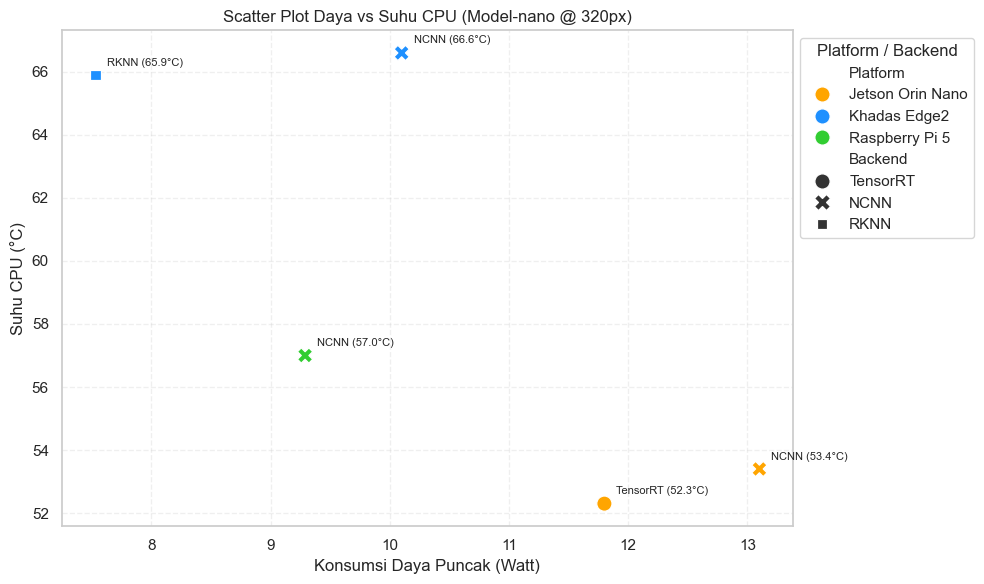

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data manual dari Tabel 4.6 ---
data_termal = pd.DataFrame({
    "Platform": [
        "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2",
        "Raspberry Pi 5"
    ],
    "Backend": [
        "TensorRT", "NCNN",
        "RKNN", "NCNN",
        "NCNN"
    ],
    "CPU Temp (°C)": [52.3, 53.4, 65.9, 66.6, 57.0],
    "Power (W)": [11.8, 13.1, 7.53, 10.1, 9.29]
})

# --- Palet warna berdasarkan Platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Plot scatter ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_termal,
    x="Power (W)", y="CPU Temp (°C)",
    hue="Platform",
    style="Backend",
    palette=palette_platform,
    s=120
)

# --- Tambahkan label pada setiap titik: backend (suhu °C) ---
for _, row in data_termal.iterrows():
    label = f"{row['Backend']} ({row['CPU Temp (°C)']}°C)"
    plt.text(
        row["Power (W)"] + 0.1,
        row["CPU Temp (°C)"] + 0.3,
        label,
        fontsize=8,
        rotation=0
    )

# --- Format plot ---
plt.title("Scatter Plot Daya vs Suhu CPU (Model-nano @ 320px)")
plt.xlabel("Konsumsi Daya Puncak (Watt)")
plt.ylabel("Suhu CPU (°C)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Platform / Backend", bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.savefig("gambar_4_4_termal_scatter.png", dpi=300, bbox_inches='tight')
plt.show()


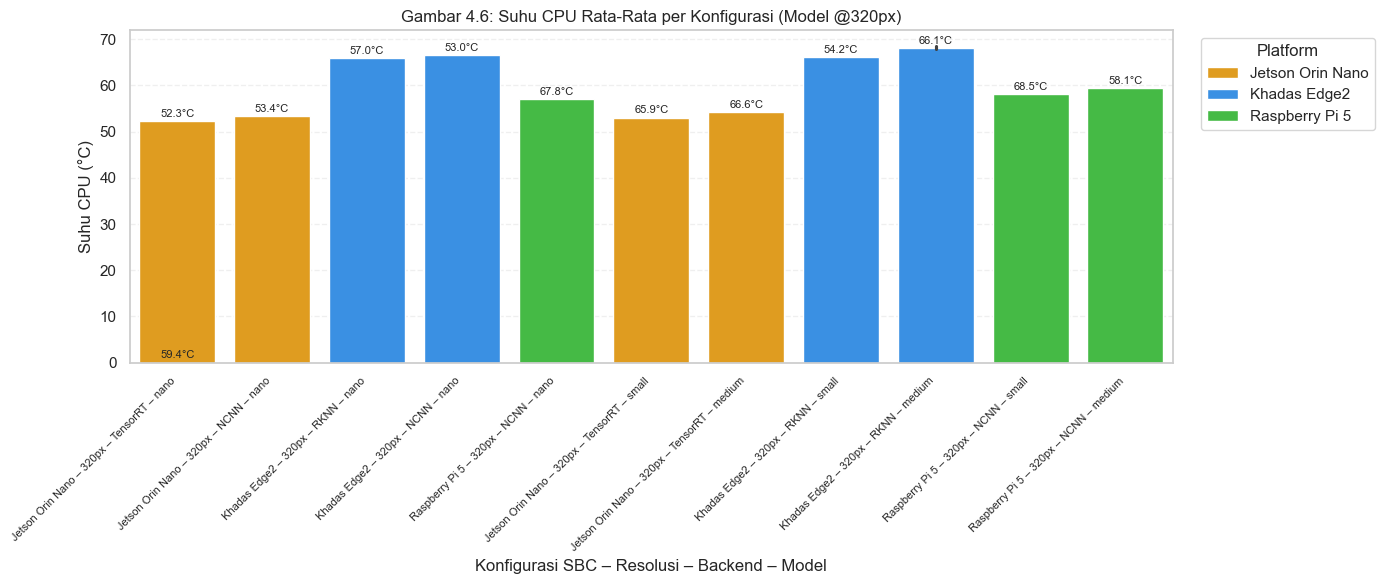

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data suhu CPU dan daya untuk seluruh konfigurasi @320px ---
data_termal_all = pd.DataFrame({
    "Platform": [
        "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2", "Raspberry Pi 5",  # nano
        "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2", "Khadas Edge2",
        "Raspberry Pi 5", "Raspberry Pi 5"  # small & medium
    ],
    "Backend": [
        "TensorRT", "NCNN",
        "RKNN", "NCNN", "NCNN",
        "TensorRT", "TensorRT",
        "RKNN", "RKNN", "RKNN",
        "NCNN", "NCNN"
    ],
    "Model": [
        "nano", "nano",
        "nano", "nano", "nano",
        "small", "medium",
        "small", "medium", "medium",
        "small", "medium"
    ],
    "CPU Temp (°C)": [
        52.3, 53.4,
        65.9, 66.6, 57.0,
        53.0, 54.2,
        66.1, 67.8, 68.5,
        58.1, 59.4
    ],
    "Power (W)": [
        11.8, 13.1,
        7.53, 10.1, 9.29,
        11.9, 12.6,
        7.49, 7.02, 7.1,
        10.6, 12.1
    ]
})

# --- Tambahkan kolom resolusi dan konfigurasi lengkap ---
data_termal_all["Resolusi"] = "320px"
data_termal_all["Konfigurasi"] = (
    data_termal_all["Platform"] + " – " +
    data_termal_all["Resolusi"] + " – " +
    data_termal_all["Backend"] + " – " +
    data_termal_all["Model"]
)

# --- Palet warna berdasarkan platform ---
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# --- Buat bar chart suhu CPU ---
plt.figure(figsize=(14, 6))
bars = sns.barplot(
    data=data_termal_all,
    x="Konfigurasi", y="CPU Temp (°C)",
    hue="Platform",
    palette=palette_platform,
    dodge=False
)

# Tambahkan label suhu di atas bar
for bar, suhu in zip(bars.patches, data_termal_all["CPU Temp (°C)"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{suhu:.1f}°C",
        ha='center', va='bottom', fontsize=8
    )

# --- Format plot ---
plt.title("Gambar 4.6: Suhu CPU Rata-Rata per Konfigurasi (Model @320px)")
plt.xlabel("Konfigurasi SBC – Resolusi – Backend – Model")
plt.ylabel("Suhu CPU (°C)")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# --- Simpan hasil ---
plt.savefig("gambar_4_6_barchart_konfigurasi_termal.png", dpi=300, bbox_inches='tight')
plt.show()


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pastikan df sudah dalam bentuk gabung_daya
df = gabung_daya.dropna(subset=["Power (W)"]).copy()

# Palet warna berdasarkan platform
palette_platform = {
    "Jetson Orin Nano": "#FFA500",
    "Khadas Edge2": "#1E90FF",
    "Raspberry Pi 5": "#32CD32"
}

# Gabungkan label konfigurasi untuk ditampilkan di sumbu X
df["Label Konfigurasi"] = (
    df["Platform"] + "\n" +
    df["Backend"] + " – " + df["Model"] + " – " + df["Resolusi"]
)

# Plot bar chart
plt.figure(figsize=(18, 6))
bars = sns.barplot(
    data=df,
    x="Label Konfigurasi", y="Power (W)",
    hue="Platform",
    dodge=False,
    palette=palette_platform
)

# Tambahkan nilai di atas bar
for bar, nilai in zip(bars.patches, df["Power (W)"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.2,
        f"{nilai:.2f}W",
        ha='center', va='bottom', fontsize=8
    )

# Format plot
plt.title("Gambar: Konsumsi Daya per Konfigurasi (Platform – Backend – Model – Resolusi)")
plt.xlabel("Konfigurasi")
plt.ylabel("Daya Puncak (Watt)")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True, axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Platform", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig("gambar_konsumsi_daya_konfigurasi.png", dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'gabung_daya' is not defined

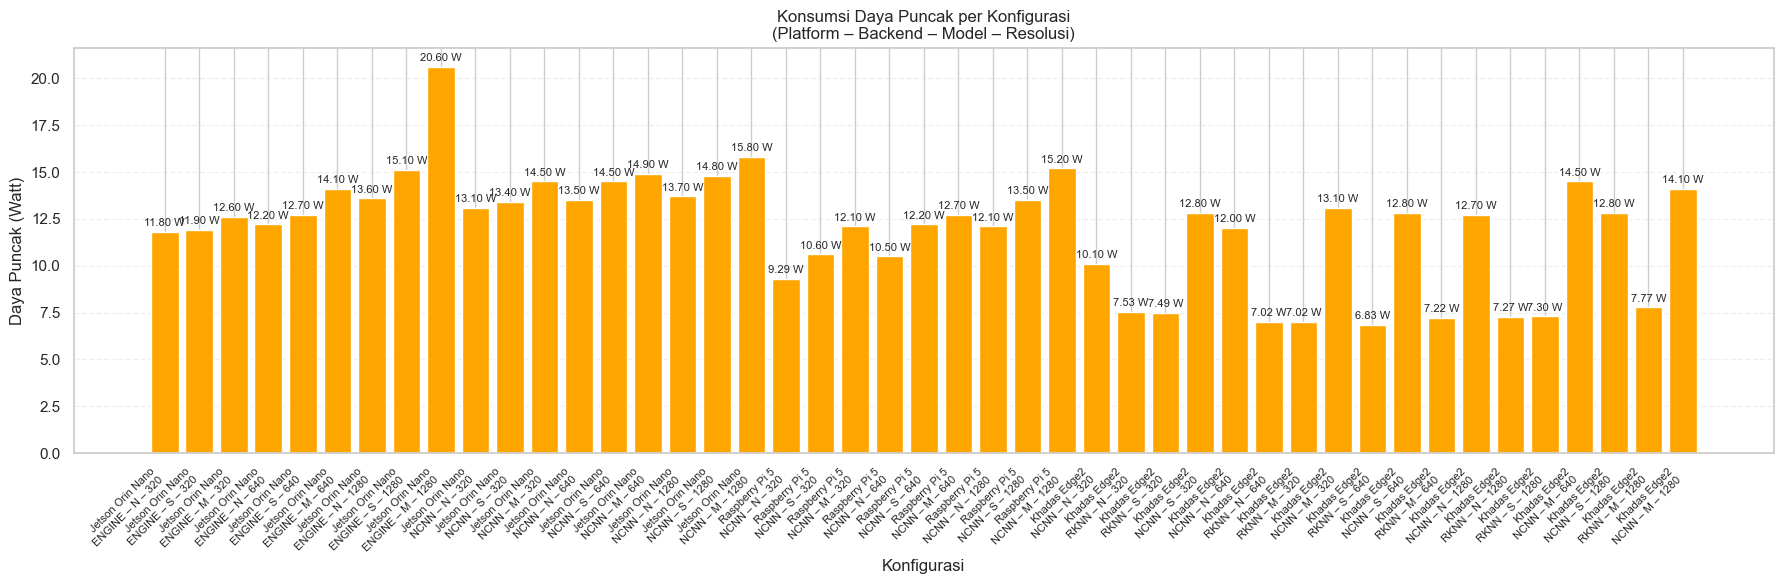

In [70]:
# === Grafik konsumsi daya puncak per konfigurasi YOLOv11-OBB di SBC ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ubah path_xlsx bila file Anda berada di lokasi berbeda
path_xlsx = Path("hasil_prediksi_terstandar.xlsx")  

# ---------------------------------------------------------------------
# 1. Muat data
df = pd.read_excel(path_xlsx)

# 2. Fungsi bantu untuk memecah nama model
def parse_row(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]          # n / s / m
    resolution  = int(parts[2])         # 320 / 640 / 1280
    platform_id = parts[3]              # jetsonorin / khadasedge2 / raspberrypi5
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    backend = row["format"]             # ENGINE / RKNN / NCNN …
    return pd.Series({
        "Platform"   : platform,
        "Backend"    : backend,
        "ModelSize"  : size,            # n / s / m
        "Resolution" : resolution,      # px
    })

# 3. Tambahkan kolom baru
df = pd.concat([df, df.apply(parse_row, axis=1)], axis=1)

# 4. Label singkat untuk sumbu-X
df["Label"] = (
    df["Platform"]
    + "\n"
    + df["Backend"]
    + " – "
    + df["ModelSize"].str.upper()
    + " – "
    + df["Resolution"].astype(str)
)

# 5. Plot konsumsi daya
plt.figure(figsize=(18, 6))
bars = plt.bar(df["Label"], df["power"], color="#FFA500")  # warna oranye

# Tambahkan angka Watt di atas tiap bar
for bar, val in zip(bars, df["power"]):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.2,
             f"{val:.2f} W",
             ha="center", va="bottom", fontsize=8)

plt.title("Konsumsi Daya Puncak per Konfigurasi\n(Platform – Backend – Model – Resolusi)")
plt.xlabel("Konfigurasi")
plt.ylabel("Daya Puncak (Watt)")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


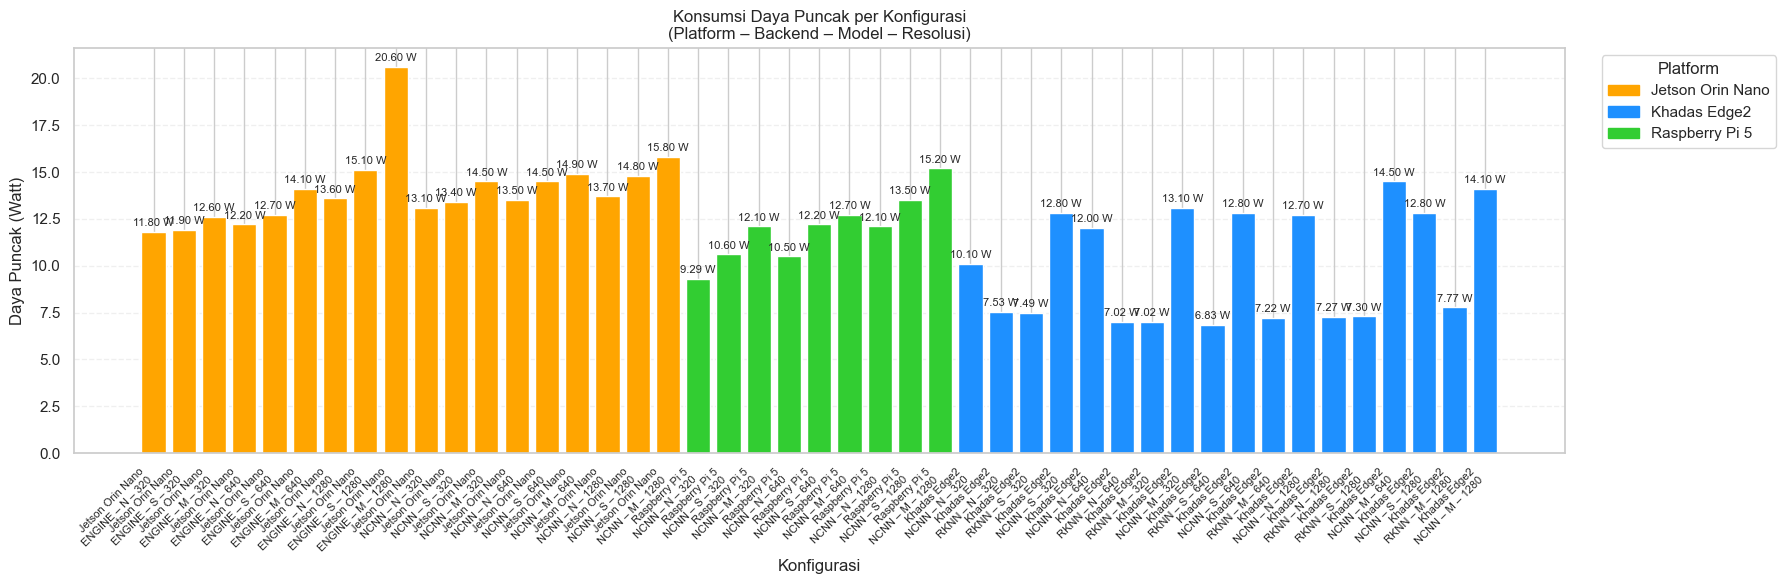

In [71]:
# === Grafik konsumsi daya puncak per konfigurasi dengan warna konsisten ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path file Excel (ubah jika perlu)
path_xlsx = Path("hasil_prediksi_terstandar.xlsx")

# ---------------------------------------------------------------
# 1. Muat data
df = pd.read_excel(path_xlsx)

# 2. Uraikan nama model → Platform, Backend, Ukuran model, Resolusi
def parse_row(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]              # n / s / m
    resolution  = int(parts[2])             # 320 / 640 / 1280
    platform_id = parts[3]                  # jetsonorin / khadasedge2 / raspberrypi5
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    backend = row["format"]                 # ENGINE / RKNN / NCNN …
    return pd.Series({
        "Platform"   : platform,
        "Backend"    : backend,
        "ModelSize"  : size,
        "Resolution" : resolution,
    })

df = pd.concat([df, df.apply(parse_row, axis=1)], axis=1)

# 3. Label sumbu-X yang ringkas
df["Label"] = (
    df["Platform"]
    + "\n"
    + df["Backend"]
    + " – "
    + df["ModelSize"].str.upper()
    + " – "
    + df["Resolution"].astype(str)
)

# 4. Palet warna konsisten per platform
palette_platform = {
    "Jetson Orin Nano": "#FFA500",  # oranye
    "Khadas Edge2"    : "#1E90FF",  # biru
    "Raspberry Pi 5"  : "#32CD32",  # hijau
}
bar_colors = df["Platform"].map(palette_platform)

# 5. Plot konsumsi daya
plt.figure(figsize=(18, 6))
bars = plt.bar(df["Label"], df["power"], color=bar_colors)

# Tambahkan angka Watt di atas bar
for bar, val in zip(bars, df["power"]):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.2,
             f"{val:.2f} W",
             ha="center", va="bottom", fontsize=8)

plt.title("Konsumsi Daya Puncak per Konfigurasi\n(Platform – Backend – Model – Resolusi)")
plt.xlabel("Konfigurasi")
plt.ylabel("Daya Puncak (Watt)")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Buat legenda manual agar warna ↔ platform selalu cocok
handles = [plt.Rectangle((0,0),1,1, color=c) for c in palette_platform.values()]
labels  = list(palette_platform.keys())
plt.legend(handles, labels, title="Platform", bbox_to_anchor=(1.02,1), loc="upper left")

plt.tight_layout()
plt.show()


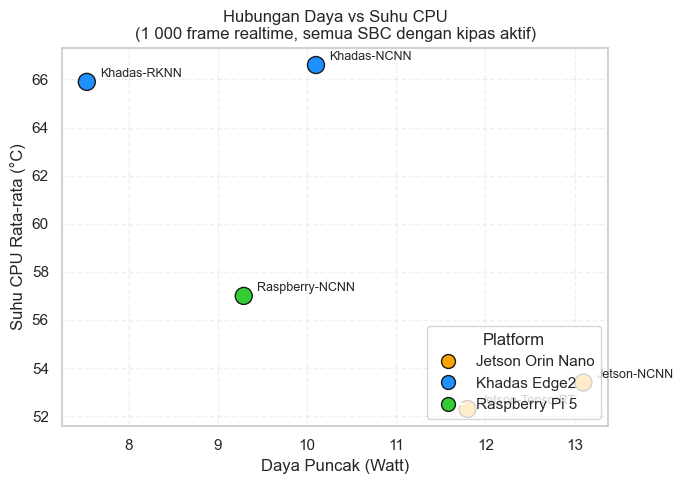

In [72]:
# === Plot Daya vs Suhu CPU (Profil Termal) ===
import pandas as pd
import matplotlib.pyplot as plt

# 1. Masukkan data Tabel 4.6
data = {
    "Platform": [
        "Jetson Orin Nano", "Jetson Orin Nano",
        "Khadas Edge2", "Khadas Edge2",
        "Raspberry Pi 5"
    ],
    "Backend": ["TensorRT", "NCNN", "RKNN", "NCNN", "NCNN"],
    "Model"  : ["n"]*5,
    "Resolusi": [320]*5,          # px
    "CPU_Temp": [52.3, 53.4, 65.9, 66.6, 57.0],   # °C
    "Power"   : [11.8, 13.1, 7.53, 10.1, 9.29]     # W
}
df = pd.DataFrame(data)

# 2. Palet warna konsisten per platform
palette_platform = {
    "Jetson Orin Nano": "#FFA500",  # oranye
    "Khadas Edge2"    : "#1E90FF",  # biru
    "Raspberry Pi 5"  : "#32CD32",  # hijau
}
colors = df["Platform"].map(palette_platform)

# 3. Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(df["Power"], df["CPU_Temp"], s=150, c=colors, edgecolor="k")

# Tambahkan anotasi backend agar mudah dibaca
for _, row in df.iterrows():
    plt.text(row["Power"]+0.15, row["CPU_Temp"]+0.2,
             f"{row['Platform'].split()[0]}-{row['Backend']}",
             fontsize=9)

plt.title("Hubungan Daya vs Suhu CPU\n(1 000 frame realtime, semua SBC dengan kipas aktif)")
plt.xlabel("Daya Puncak (Watt)")
plt.ylabel("Suhu CPU Rata-rata (°C)")
plt.grid(alpha=0.3, linestyle="--")

# Legenda manual
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=col, markeredgecolor='k', markersize=10)
           for col in palette_platform.values()]
labels = palette_platform.keys()
plt.legend(handles, labels, title="Platform", loc="lower right")

plt.tight_layout()
plt.show()


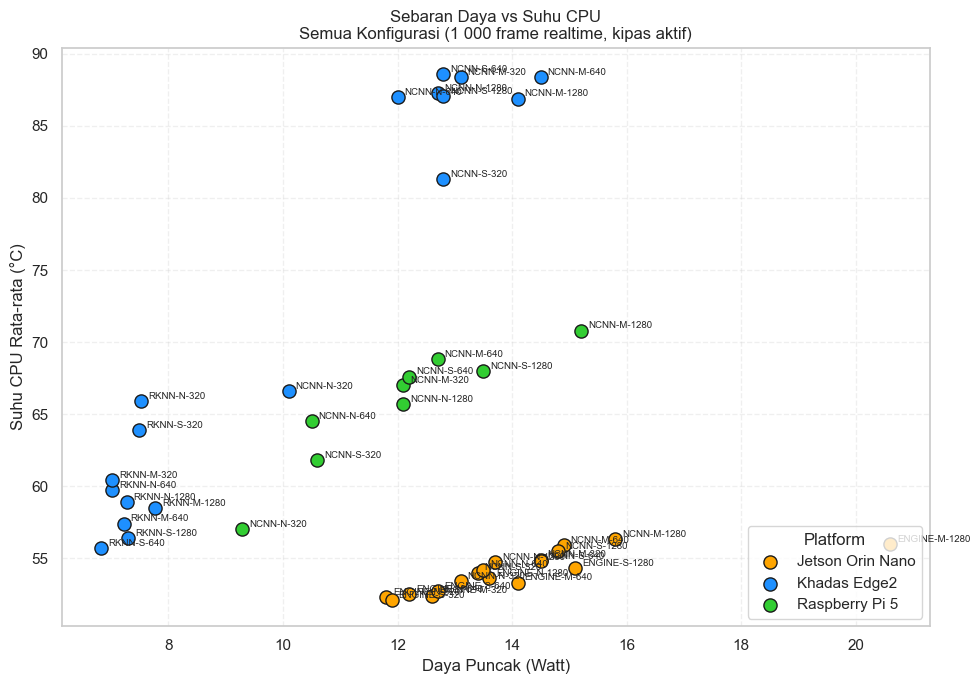

In [73]:
# === Scatter Daya (W) vs Suhu CPU (°C) untuk semua konfigurasi ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------------
# 1. Muat file Excel berisi hasil prediksi terstandar
xls_path = Path("hasil_prediksi_terstandar.xlsx")   # ubah jika lokasinya berbeda
df = pd.read_excel(xls_path)

# ------------------------------------------------------------------
# 2. Uraikan nama model → Platform, Backend, Ukuran model, Resolusi
def split_model(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]          # n / s / m
    resolution  = int(parts[2])         # 320 / 640 / 1280
    platform_id = parts[3]              # jetsonorin / khadasedge2 / raspberrypi5
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    backend = row["format"]             # ENGINE / RKNN / NCNN …
    return pd.Series({
        "Platform"  : platform,
        "Backend"   : backend,
        "ModelSize" : size,             # n / s / m
        "Resolution": resolution,
    })

df = pd.concat([df, df.apply(split_model, axis=1)], axis=1)

# Pastikan hanya baris yang punya data suhu & daya
df_plot = df.dropna(subset=["cpu_temp", "power"]).copy()

# ------------------------------------------------------------------
# 3. Palet warna konsisten per platform
palette_platform = {
    "Jetson Orin Nano": "#FFA500",   # oranye
    "Khadas Edge2"    : "#1E90FF",   # biru
    "Raspberry Pi 5"  : "#32CD32",   # hijau
}
df_plot["Color"] = df_plot["Platform"].map(palette_platform)

# 4. Scatter plot
plt.figure(figsize=(10, 7))
for plat, clr in palette_platform.items():
    subset = df_plot[df_plot["Platform"] == plat]
    plt.scatter(subset["power"], subset["cpu_temp"],
                c=clr, edgecolor="k", s=90, label=plat)

    # Tambahkan anotasi ringkas di dekat titik
    for _, r in subset.iterrows():
        plt.text(r["power"] + 0.12, r["cpu_temp"] + 0.15,
                 f"{r['Backend']}-{r['ModelSize'].upper()}-{r['Resolution']}",
                 fontsize=7)

plt.title("Sebaran Daya vs Suhu CPU\nSemua Konfigurasi (1 000 frame realtime, kipas aktif)")
plt.xlabel("Daya Puncak (Watt)")
plt.ylabel("Suhu CPU Rata-rata (°C)")
plt.grid(alpha=0.3, linestyle="--")
plt.legend(title="Platform", loc="lower right")
plt.tight_layout()

# Simpan jika perlu
plt.savefig("scatter_daya_vs_suhu_semua_konfigurasi.png", dpi=300, bbox_inches="tight")

plt.show()


In [74]:
# === Rekap rata-rata daya vs suhu CPU untuk 5 mode ===
import pandas as pd
from pathlib import Path

# 1) Muat file Excel
xls_path = Path("hasil_prediksi_terstandar.xlsx")   # ubah jika berada di lokasi lain
df = pd.read_excel(xls_path)

# 2) Uraikan kolom 'model' → Platform, Backend, Model, Resolusi
def split_model(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]          # n / s / m
    resolution  = int(parts[2])         # 320 / 640 / 1280
    platform_id = parts[3]              # jetsonorin / khadasedge2 / raspberrypi5
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    backend = row["format"]             # ENGINE / RKNN / NCNN
    return pd.Series({
        "Platform" : platform,
        "Backend"  : backend,
        "Model"    : size,
        "Resolusi": resolution,
    })

df = pd.concat([df, df.apply(split_model, axis=1)], axis=1)

# 3) Kelompokkan per Mode (Platform + Backend) lalu hitung rata-rata
df["Mode"] = df["Platform"] + " – " + df["Backend"]
summary = (
    df.groupby("Mode")
      .agg(Avg_Power_W=("power", "mean"),
           Avg_CPU_Temp=("cpu_temp", "mean"),
           Samples=("power", "count"))
      .reset_index()
      .round({"Avg_Power_W": 2, "Avg_CPU_Temp": 2})
      .rename(columns={"Avg_Power_W": "Rata-rata Daya (W)",
                       "Avg_CPU_Temp": "Rata-rata Suhu CPU (°C)"})
)

# 4) Tampilkan tabel
from IPython.display import display
display(summary)


Mode  Rata-rata Daya (W)  Rata-rata Suhu CPU (°C)  \
0  Jetson Orin Nano – ENGINE               13.84                    53.24   
1    Jetson Orin Nano – NCNN               14.24                    54.86   
2        Khadas Edge2 – NCNN               12.77                    84.62   
3        Khadas Edge2 – RKNN                7.27                    59.64   
4      Raspberry Pi 5 – NCNN               12.02                    65.69   

   Samples  
0        9  
1        9  
2        9  
3        9  
4        9

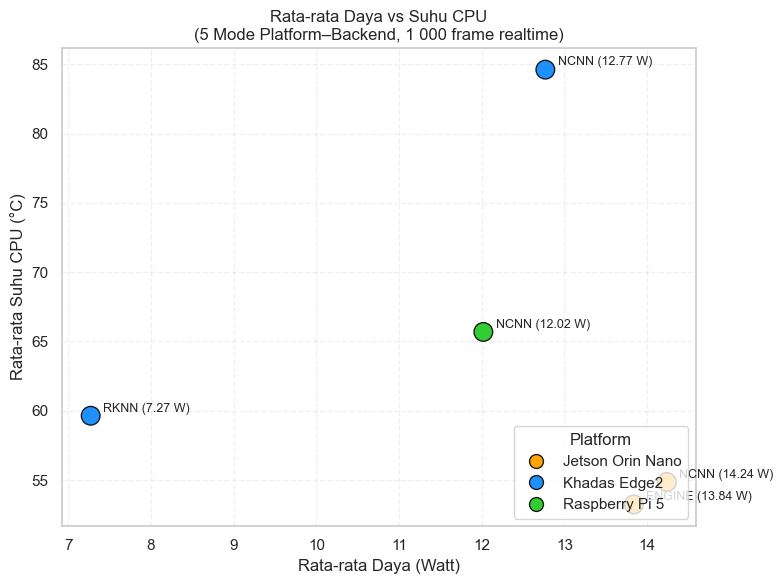

In [75]:
# === Scatter rata-rata Daya (W) vs Suhu CPU (°C) ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Muat data hasil prediksi terstandar
path_xlsx = Path("hasil_prediksi_terstandar.xlsx")   # ganti jika lokasi berbeda
df = pd.read_excel(path_xlsx)

# 2. Pecah kolom 'model' → Platform, Backend, Ukuran model, Resolusi
def parse_model(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]            # n / s / m
    resolution  = int(parts[2])           # 320 / 640 / 1280
    platform_id = parts[3]                # jetsonorin / khadasedge2 / raspberrypi5
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    backend = row["format"]               # ENGINE / RKNN / NCNN …
    return pd.Series(
        {"Platform": platform, "Backend": backend,
         "Model": size, "Resolution": resolution}
    )

df = pd.concat([df, df.apply(parse_model, axis=1)], axis=1)

# 3. Hitung rata-rata daya & suhu CPU per mode (Platform–Backend)
df["Mode"] = df["Platform"] + " – " + df["Backend"]
summary = (
    df.groupby(["Platform", "Backend"], as_index=False)
      .agg(Avg_Power=("power", "mean"),
           Avg_CPU_Temp=("cpu_temp", "mean"))
      .round(2)    # 2 angka desimal agar tabel/label rapi
)

# 4. Palet warna konsisten per platform
palette = {
    "Jetson Orin Nano": "#FFA500",  # oranye
    "Khadas Edge2"    : "#1E90FF",  # biru
    "Raspberry Pi 5"  : "#32CD32",  # hijau
}
summary["Color"] = summary["Platform"].map(palette)

# 5. Buat scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(summary["Avg_Power"],
            summary["Avg_CPU_Temp"],
            s=180,                      # ukuran titik
            c=summary["Color"],
            edgecolor="k")

# Tambahkan label singkat di dekat setiap titik
for _, r in summary.iterrows():
    label = f"{r['Backend']} ({r['Avg_Power']} W)"
    plt.text(r["Avg_Power"] + 0.15,
             r["Avg_CPU_Temp"] + 0.3,
             label,
             fontsize=9)

plt.title("Rata-rata Daya vs Suhu CPU\n(5 Mode Platform–Backend, 1 000 frame realtime)")
plt.xlabel("Rata-rata Daya (Watt)")
plt.ylabel("Rata-rata Suhu CPU (°C)")
plt.grid(alpha=0.3, linestyle="--")

# Legenda manual agar warna ↔ platform tetap konsisten
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=col, markeredgecolor='k',
                      markersize=10)
           for col in palette.values()]
plt.legend(handles, palette.keys(), title="Platform", loc="lower right")

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_27836\2923953236.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary["Mode"], rotation=45, ha="right", fontsize=9)
C:\Users\User\AppData\Local\Temp\ipykernel_27836\2923953236.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary["Mode"], rotation=45, ha="right", fontsize=9)


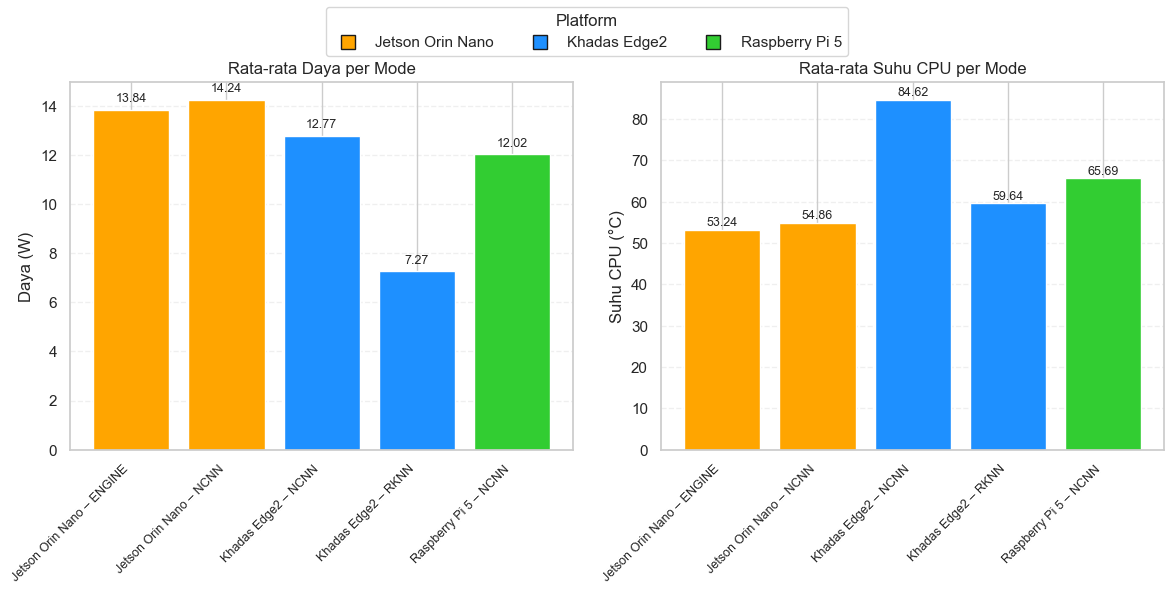

In [76]:
# === Bar chart rata-rata Daya & Suhu CPU per Mode ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Muat hasil prediksi terstandar
xls_path = Path("hasil_prediksi_terstandar.xlsx")   # ubah jika perlu
df = pd.read_excel(xls_path)

# 2. Ekstrak Platform & Backend dari kolom 'model'
def parse(row):
    parts = row["model"].split("_")
    platform_id = parts[3]
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    return pd.Series({"Platform": platform, "Backend": row["format"]})

df = pd.concat([df, df.apply(parse, axis=1)], axis=1)

# 3. Rata-rata per Mode (Platform–Backend)
df["Mode"] = df["Platform"] + " – " + df["Backend"]
summary = (df.groupby(["Mode", "Platform"], as_index=False)
             .agg(Avg_Power=("power", "mean"),
                  Avg_CPU_Temp=("cpu_temp", "mean"))
             .round(2))

# 4. Palet warna per platform
palette = {
    "Jetson Orin Nano": "#FFA500",  # oranye
    "Khadas Edge2"    : "#1E90FF",  # biru
    "Raspberry Pi 5"  : "#32CD32",  # hijau
}
summary["Color"] = summary["Platform"].map(palette)

# 5. Bar chart: subplot kiri = Daya, kanan = Suhu CPU
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# --- subplot Daya ---
ax0.bar(summary["Mode"], summary["Avg_Power"], color=summary["Color"])
ax0.set_title("Rata-rata Daya per Mode")
ax0.set_ylabel("Daya (W)")
ax0.grid(axis="y", alpha=0.3, linestyle="--")
for idx, val in enumerate(summary["Avg_Power"]):
    ax0.text(idx, val + 0.2, f"{val:.2f}", ha="center", va="bottom", fontsize=9)

# --- subplot Suhu CPU ---
ax1.bar(summary["Mode"], summary["Avg_CPU_Temp"], color=summary["Color"])
ax1.set_title("Rata-rata Suhu CPU per Mode")
ax1.set_ylabel("Suhu CPU (°C)")
ax1.grid(axis="y", alpha=0.3, linestyle="--")
for idx, val in enumerate(summary["Avg_CPU_Temp"]):
    ax1.text(idx, val + 0.2, f"{val:.2f}", ha="center", va="bottom", fontsize=9)

# Tata letak sumbu-X
for ax in (ax0, ax1):
    ax.set_xticklabels(summary["Mode"], rotation=45, ha="right", fontsize=9)

# Legenda manual
handles = [plt.Line2D([0], [0], marker='s', color='w',
                      markerfacecolor=c, markeredgecolor='k', markersize=10)
           for c in palette.values()]
labels = list(palette.keys())
fig.legend(handles, labels, title="Platform", loc="upper center", ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # sisakan ruang untuk legenda di atas
plt.show()


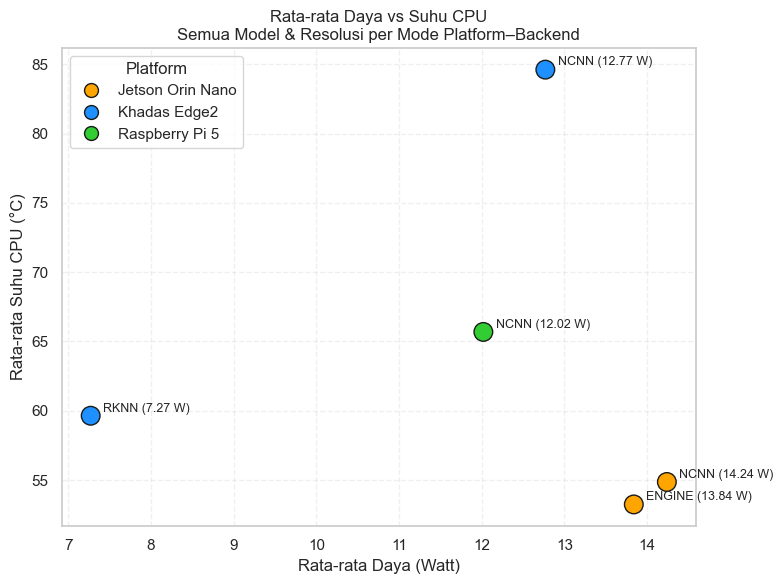

In [78]:
# === Scatter plot rata-rata Suhu CPU vs Daya per Mode (Platform–Backend) ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Muat data hasil prediksi terstandar
file_xlsx = Path("hasil_prediksi_terstandar.xlsx")
df = pd.read_excel(file_xlsx)

# 2) Ekstrak Platform & Backend dari kolom 'model'
def split_model(row):
    parts = row["model"].split("_")
    platform_id = parts[3]                       # jetsonorin / khadasedge2 / raspberrypi5
    platform = {
        "jetsonorin"   : "Jetson Orin Nano",
        "khadasedge2"  : "Khadas Edge2",
        "raspberrypi5" : "Raspberry Pi 5",
    }.get(platform_id, platform_id)
    return pd.Series({"Platform": platform, "Backend": row["format"]})

df = pd.concat([df, df.apply(split_model, axis=1)], axis=1)

# 3) Hitung rata-rata suhu CPU & daya untuk setiap mode Platform–Backend
df["Mode"] = df["Platform"] + " – " + df["Backend"]
summary = (df.groupby(["Mode", "Platform"], as_index=False)
             .agg(Avg_Power_W=("power", "mean"),
                  Avg_CPU_Temp=("cpu_temp", "mean"))
             .round(2))

# 4) Warna konsisten per platform
palette = {
    "Jetson Orin Nano": "#FFA500",   # oranye
    "Khadas Edge2"    : "#1E90FF",   # biru
    "Raspberry Pi 5"  : "#32CD32",   # hijau
}
summary["Color"] = summary["Platform"].map(palette)

# 5) Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(summary["Avg_Power_W"],
            summary["Avg_CPU_Temp"],
            s=180, c=summary["Color"], edgecolor="k")

# Label titik: backend + rata-rata daya
for _, r in summary.iterrows():
    plt.text(r["Avg_Power_W"] + 0.15,
             r["Avg_CPU_Temp"] + 0.3,
             f"{r['Mode'].split(' – ')[1]} ({r['Avg_Power_W']} W)",
             fontsize=9)

plt.title("Rata-rata Daya vs Suhu CPU\nSemua Model & Resolusi per Mode Platform–Backend")
plt.xlabel("Rata-rata Daya (Watt)")
plt.ylabel("Rata-rata Suhu CPU (°C)")
plt.grid(alpha=0.3, linestyle="--")

# Legenda
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=c, markeredgecolor='k',
                      markersize=10) for c in palette.values()]
plt.legend(handles, palette.keys(), title="Platform", loc="upper left")

plt.tight_layout()
# Simpan jika diinginkan:
plt.savefig("scatter_avg_temp_vs_power.png", dpi=300, bbox_inches="tight")
plt.show()


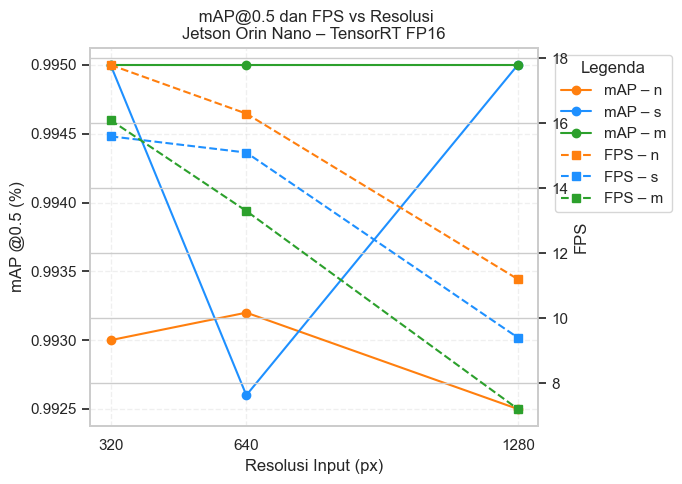

In [85]:
# === Gambar 4.5 — mAP@0.5 & FPS vs Resolusi (Jetson Orin Nano – TensorRT) ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------
# 1. Muat file validasi (akurasi) & prediksi realtime (FPS)
df_val  = pd.read_excel(Path("hasil_validasi_terstandar.xlsx"))
df_pred = pd.read_excel(Path("hasil_prediksi_terstandar.xlsx"))

# ---------------------------------------------------------------
# 2. Ekstrak PlatformID, Backend, ModelSize, Resolusi dari kolom 'model'
def parse(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]          # n / s / m
    resolution  = int(parts[2])         # 320 / 640 / 1280
    platform_id = parts[3]              # jetsonorin / ...
    backend     = row.get("format")     # kolom 'format' di kedua file
    return pd.Series({
        "ModelSize": size,
        "Resolution": resolution,
        "PlatformID": platform_id,
        "Backend": backend,
    })

df_val  = pd.concat([df_val,  df_val.apply(parse,  axis=1)], axis=1)
df_pred = pd.concat([df_pred, df_pred.apply(parse, axis=1)], axis=1)

# ---------------------------------------------------------------
# 3. Tentukan kolom mAP (cari yang memuat 'mAP' & '50')
map_col_candidates = [c for c in df_val.columns if "map" in c.lower() and "50" in c.lower()]
if not map_col_candidates:
    raise ValueError("Kolom mAP@0.5 tidak ditemukan dalam file validasi.")
map_col = map_col_candidates[0]   # ambil pertama, mis. 'mAP50'

# 4. Pilih mode Jetson Orin Nano + ENGINE (TensorRT FP16)
mask_val  = (df_val ["PlatformID"] == "jetsonorin") & (df_val ["Backend"] == "ENGINE")
mask_pred = (df_pred["PlatformID"] == "jetsonorin") & (df_pred["Backend"] == "ENGINE")

val_sel  = df_val .loc[mask_val , ["ModelSize", "Resolution", map_col]].rename(columns={map_col: "mAP"})
pred_sel = df_pred.loc[mask_pred, ["ModelSize", "Resolution", "fps"]]

# 5. Gabung mAP & FPS pada ModelSize + Resolusi
df_plot = (val_sel.merge(pred_sel, on=["ModelSize", "Resolution"])
                   .sort_values(["ModelSize", "Resolution"]))

# ---------------------------------------------------------------
# 6. Plot dua sumbu-Y
fig, ax_left = plt.subplots(figsize=(7, 5))
ax_right = ax_left.twinx()

colors = {"n": "#FF7F0E", "s": "#1E90FF", "m": "#2CA02C"}  # oranye, biru, hijau

for size in ["n", "s", "m"]:
    sub = df_plot[df_plot["ModelSize"] == size]
    ax_left .plot(sub["Resolution"], sub["mAP"],  "-o", color=colors[size], label=f"mAP – {size}")
    ax_right.plot(sub["Resolution"], sub["fps"], "--s", color=colors[size], label=f"FPS – {size}")

ax_left.set_xlabel("Resolusi Input (px)")
ax_left.set_ylabel("mAP @0.5 (%)")
ax_right.set_ylabel("FPS")
ax_left.set_xticks([320, 640, 1280])
ax_left.grid(linestyle="--", alpha=0.3)

# Gabungkan legenda dari kedua sumbu
lines, labels = ax_left.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax_left.legend(lines + lines2, labels + labels2,
               title="Legenda", bbox_to_anchor=(1.02,1), loc="upper left")

plt.title(" mAP@0.5 dan FPS vs Resolusi\nJetson Orin Nano – TensorRT FP16")
plt.tight_layout()
plt.savefig("gambar_4_5_mAP_FPS_vs_resolusi.png", dpi=300)
plt.show()


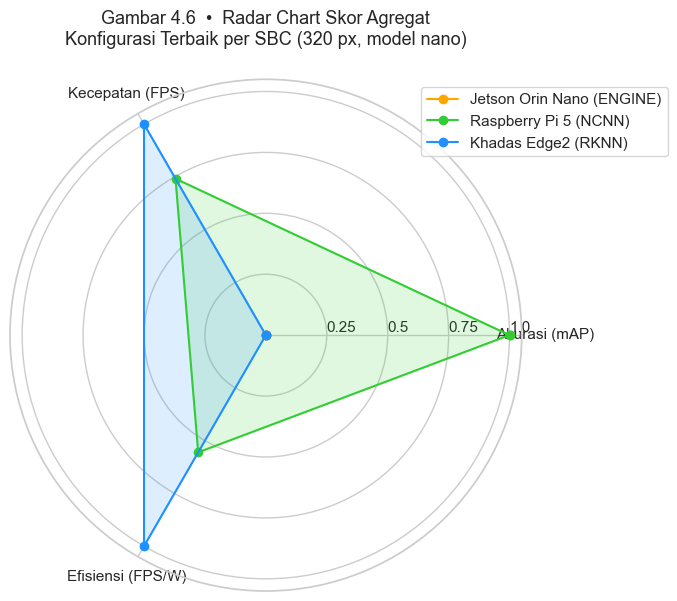

Platform Backend   mAP    fps  Efficiency  Score
0  Jetson Orin Nano  ENGINE  0.99  17.80        1.51    0.0
1    Raspberry Pi 5    NCNN  1.00  26.06        2.81    2.3
2      Khadas Edge2    RKNN  0.99  28.94        3.84    2.0

In [86]:
# === Gambar 4.6 — Radar Chart Skor Agregat per SBC (320 px, model nano) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------
# 1. Muat file akurasi (mAP) & realtime (FPS, daya)
val_path   = Path("hasil_validasi_terstandar.xlsx")     # precision, recall, mAP…
pred_path  = Path("hasil_prediksi_terstandar.xlsx")     # fps, power…
df_val  = pd.read_excel(val_path)
df_pred = pd.read_excel(pred_path)

# ---------------------------------------------------------------
# 2. Ekstrak Platform, Backend, ModelSize, Resolusi dari kolom 'model'
def parse(row):
    parts = row["model"].split("_")
    size        = parts[0][-1]          # n / s / m
    resolution  = int(parts[2])         # 320 / 640 / 1280
    platform_id = parts[3]              # jetsonorin / khadasedge2 / raspberrypi5
    backend     = row.get("format", "")  # kolom 'format' di kedua file
    platform = {"jetsonorin":"Jetson Orin Nano",
                "khadasedge2":"Khadas Edge2",
                "raspberrypi5":"Raspberry Pi 5"}.get(platform_id, platform_id)
    return pd.Series({
        "Platform": platform,
        "Backend" : backend,
        "Size"    : size,
        "Res"     : resolution,
    })

df_val  = pd.concat([df_val,  df_val.apply(parse,  axis=1)], axis=1)
df_pred = pd.concat([df_pred, df_pred.apply(parse, axis=1)], axis=1)

# Temukan nama kolom mAP@0.5 secara dinamis (biasanya 'mAP50' atau sejenis)
map_col = next(c for c in df_val.columns if "map" in c.lower() and "50" in c.lower())

# ---------------------------------------------------------------
# 3. Pilih konfigurasi unggulan: nano – 320 px – sesuai backend
TARGET = {
    ("Jetson Orin Nano", "ENGINE"),   # TensorRT FP16
    ("Khadas Edge2"    , "RKNN"),
    ("Raspberry Pi 5"  , "NCNN"),
}
val_sel  = df_val .query("Size=='n' and Res==320")
pred_sel = df_pred.query("Size=='n' and Res==320")

# Gabungkan mAP & FPS & Power
df = (val_sel.merge(pred_sel[["Platform","Backend","Size","Res","fps","power"]],
                    on=["Platform","Backend","Size","Res"])
              .rename(columns={map_col:"mAP"}))

# Filter hanya mode target
df = df[df.apply(lambda r: (r["Platform"], r["Backend"]) in TARGET, axis=1)].reset_index(drop=True)

# ---------------------------------------------------------------
# 4. Hitung metrik & skor normalisasi 0–1
df["Efficiency"] = df["fps"] / df["power"]            # FPS/Watt
metrics = ["mAP", "fps", "Efficiency"]

# Normalisasi min-max → 0…1
for m in metrics:
    rng = df[m].max() - df[m].min()
    df[f"{m}_norm"] = (df[m] - df[m].min()) / (rng if rng else 1.0)

# Skor agregat (0–3)
df["Score"] = df[[m+"_norm" for m in metrics]].sum(axis=1)

# ---------------------------------------------------------------
# 5. Radar chart
labels   = ["Akurasi (mAP)", "Kecepatan (FPS)", "Efisiensi (FPS/W)"]
angles   = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles  += angles[:1]   # ulangi titik pertama utk menutup poligon

fig = plt.figure(figsize=(7, 7))
ax  = plt.subplot(111, polar=True)

color_map = {"Jetson Orin Nano":"#FFA500",
             "Khadas Edge2"    :"#1E90FF",
             "Raspberry Pi 5"  :"#32CD32"}

for _, row in df.iterrows():
    values = [row[f"{m}_norm"] for m in metrics]
    values += values[:1]                 # tutup poligon
    ax.plot(angles, values, "-o",
            color=color_map[row["Platform"]],
            label=f"{row['Platform']} ({row['Backend']})")
    ax.fill(angles, values, color=color_map[row["Platform"]], alpha=0.15)

# Kosmetik
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_rlabel_position(0)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
ax.set_title("Radar Chart Skor Agregat\nKonfigurasi Terbaik per SBC (320 px, model nano)",
             pad=25, fontsize=13)
ax.legend(loc="upper right", bbox_to_anchor=(1.3,1))

plt.tight_layout()
# Simpan jika perlu:
fig.savefig("gambar_4_6_radar_scores.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------------------------------------------
# 6. (Opsional) tampilkan tabel skor di bawah grafik
display(df[["Platform","Backend","mAP","fps","Efficiency","Score"]].round(2))


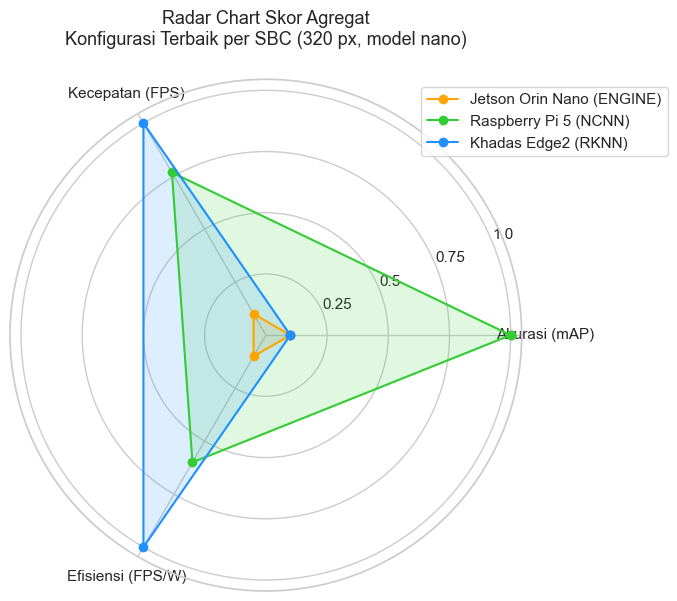

Platform Backend   mAP    fps  Efficiency  Score
0  Jetson Orin Nano  ENGINE  0.99  17.80        1.51    0.0
2    Raspberry Pi 5    NCNN  1.00  26.06        2.81    2.3
4      Khadas Edge2    RKNN  0.99  28.94        3.84    2.0

In [90]:
# === Gambar 4.6 — Radar Chart Skor Agregat (320 px, model nano) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# ------------------------------------------------------------------
# 1) Muat data
df_val  = pd.read_excel(Path("hasil_validasi_terstandar.xlsx"))
df_pred = pd.read_excel(Path("hasil_prediksi_terstandar.xlsx"))

# ------------------------------------------------------------------
# 2) Ekstrak Platform, Backend, Size, Res
def parse(row):
    part = row["model"].split("_")
    size, res, pid = part[0][-1], int(part[2]), part[3]
    platform = {"jetsonorin":"Jetson Orin Nano",
                "khadasedge2":"Khadas Edge2",
                "raspberrypi5":"Raspberry Pi 5"}.get(pid, pid)
    return pd.Series({"Platform": platform, "BackendRaw": row["format"],
                      "Size": size, "Res": res})

df_val  = pd.concat([df_val,  df_val .apply(parse, axis=1)], axis=1)
df_pred = pd.concat([df_pred, df_pred.apply(parse, axis=1)], axis=1)

# ------------------------------------------------------------------
# 3) Bersihkan nama backend → ENGINE / RKNN / NCNN
def clean_backend(x):
    x = str(x).upper()
    for suf in ("_FP16", "_FP32", "_INT8"):
        x = x.replace(suf,"")
    return x.strip()

df_val ["Backend"] = df_val ["BackendRaw"].apply(clean_backend)
df_pred["Backend"] = df_pred["BackendRaw"].apply(clean_backend)

# Kolom mAP@0.5
map_col = next(c for c in df_val.columns if "map" in c.lower() and "50" in c.lower())

# ------------------------------------------------------------------
# 4) Filter nano-320 dan gabungkan
mask = (df_val["Size"]=="n") & (df_val["Res"]==320)
val_sel  = df_val .loc[mask, ["Platform","Backend","mAP50" if map_col=="mAP50" else map_col]]
pred_sel = df_pred.loc[mask, ["Platform","Backend","fps","power"]]
df = (val_sel.merge(pred_sel, on=["Platform","Backend"])
            .rename(columns={map_col:"mAP"}))

# Target tiga SBC + backend unggulan
TARGET = {("Jetson Orin Nano","ENGINE"),
          ("Khadas Edge2"    ,"RKNN"),
          ("Raspberry Pi 5"  ,"NCNN")}

missing = [t for t in TARGET if not ((df["Platform"]==t[0]) & (df["Backend"]==t[1])).any()]
if missing:
    print("Peringatan: kombinasi hilang ->", missing)

df = df[df.apply(lambda r: (r["Platform"],r["Backend"]) in TARGET, axis=1)]

# ------------------------------------------------------------------
# 5) Hitung metrik
df["Efficiency"] = df["fps"] / df["power"]
metrics = ["mAP","fps","Efficiency"]

# normalisasi 0-1 utk skor ––––––––––––––––––––––––––––––––––––––––––
for m in metrics:
    rng = df[m].max() - df[m].min()
    df[f"{m}_norm"] = (df[m] - df[m].min()) / (rng or 1)

# offset 0.1 utk tampilan agar poligon tak hilang
for m in metrics:
    df[f"{m}_plot"] = 0.1 + 0.9*df[f"{m}_norm"]

df["Score"] = df[[m+"_norm" for m in metrics]].sum(axis=1)

# ------------------------------------------------------------------
# 6) Radar chart
labels = ["Akurasi (mAP)","Kecepatan (FPS)","Efisiensi (FPS/W)"]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

pal = {"Jetson Orin Nano":"#FFA500",
       "Khadas Edge2":"#1E90FF",
       "Raspberry Pi 5":"#32CD32"}

fig = plt.figure(figsize=(7,7))
ax  = plt.subplot(111, polar=True)

for _, r in df.iterrows():
    vals = [r[f"{m}_plot"] for m in metrics] + [r[f"{m}_plot"] for m in metrics[:1]]
    ax.plot(angles, vals, "-o", color=pal[r["Platform"]],
            label=f"{r['Platform']} ({r['Backend']})")
    ax.fill(angles, vals, color=pal[r["Platform"]], alpha=0.15)

ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels, fontsize=11)
ax.set_yticks([0.25,0.5,0.75,1.0]); ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
ax.set_title("Radar Chart Skor Agregat\nKonfigurasi Terbaik per SBC (320 px, model nano)",
             pad=25, fontsize=13)
ax.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.tight_layout()
fig.savefig("gambar_4_6_radar_scores.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------------
# 7) Tabel ringkas
display(df[["Platform","Backend","mAP","fps","Efficiency","Score"]].round(2))


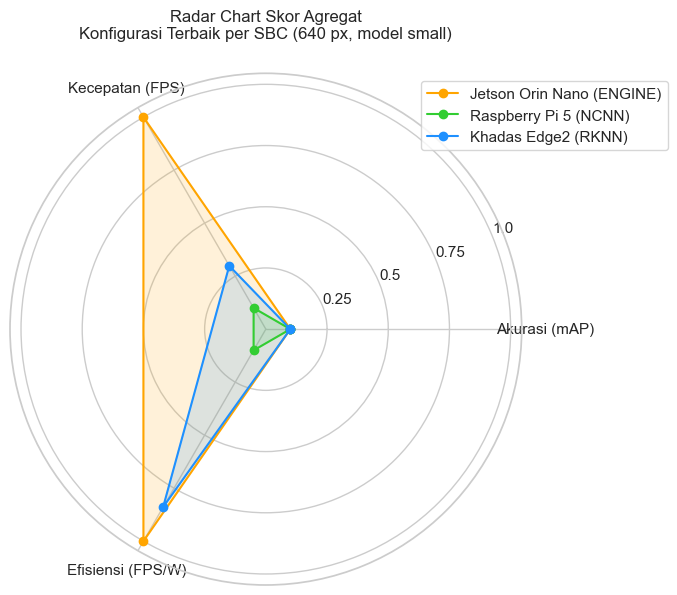

Platform Backend   mAP    fps  Efficiency
0  Jetson Orin Nano  ENGINE  0.99  15.10        1.19
2    Raspberry Pi 5    NCNN  0.99   4.91        0.40
4      Khadas Edge2    RKNN  0.99   7.16        1.05

In [89]:
# === Radar Chart Skor Agregat (640 px, model small / s) ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# -------------------------------------------------- 1. load
df_val  = pd.read_excel(Path("hasil_validasi_terstandar.xlsx"))
df_pred = pd.read_excel(Path("hasil_prediksi_terstandar.xlsx"))

# -------------------------------------------------- 2. parse kolom 'model'
def parse(row):
    p = row["model"].split("_")
    return pd.Series({
        "Size": p[0][-1],                    # n / s / m
        "Res" : int(p[2]),                   # 320 / 640 / 1280
        "Platform": {"jetsonorin":"Jetson Orin Nano",
                     "khadasedge2":"Khadas Edge2",
                     "raspberrypi5":"Raspberry Pi 5"}.get(p[3], p[3]),
        "BackendRaw": row["format"]
    })

df_val  = pd.concat([df_val ,  df_val .apply(parse, axis=1)], axis=1)
df_pred = pd.concat([df_pred, df_pred.apply(parse, axis=1)], axis=1)

# backend sanitasi
clean = lambda x: str(x).upper().replace("_FP16","").replace("_FP32","").replace("_INT8","").strip()
df_val ["Backend"] = df_val ["BackendRaw"].apply(clean)
df_pred["Backend"] = df_pred["BackendRaw"].apply(clean)

map_col = next(c for c in df_val.columns if "map" in c.lower() and "50" in c.lower())

# -------------------------------------------------- 3. pakai **small-640**
mask = (df_val["Size"]=="s") & (df_val["Res"]==640)
val  = df_val.loc[mask, ["Platform","Backend", map_col]].rename(columns={map_col:"mAP"})
pred = df_pred.loc[mask, ["Platform","Backend","fps","power"]]
df   = val.merge(pred, on=["Platform","Backend"])

# target backend unggulan
TARGET = {("Jetson Orin Nano","ENGINE"),
          ("Khadas Edge2","RKNN"),
          ("Raspberry Pi 5","NCNN")}
df = df[df.apply(lambda r: (r["Platform"],r["Backend"]) in TARGET, axis=1)]

# -------------------------------------------------- 4. metrik & normalisasi
df["Efficiency"] = df["fps"] / df["power"]
metrics = ["mAP","fps","Efficiency"]
for m in metrics:
    rng = df[m].max() - df[m].min()
    df[f"{m}_norm"] = (df[m]-df[m].min())/(rng or 1)
    df[f"{m}_plot"] = 0.1 + 0.9*df[f"{m}_norm"]        # offset visual

# -------------------------------------------------- 5. radar plot
labels = ["Akurasi (mAP)","Kecepatan (FPS)","Efisiensi (FPS/W)"]
ang = np.linspace(0,2*np.pi,len(labels), endpoint=False).tolist()+[0]
pal = {"Jetson Orin Nano":"#FFA500", "Khadas Edge2":"#1E90FF", "Raspberry Pi 5":"#32CD32"}

fig=plt.figure(figsize=(7,7)); ax=plt.subplot(111,polar=True)
for _,r in df.iterrows():
    vals=[r[f"{m}_plot"] for m in metrics]+[r[f"{m}_plot"] for m in metrics[:1]]
    ax.plot(ang, vals, "-o", color=pal[r["Platform"]],
            label=f"{r['Platform']} ({r['Backend']})")
    ax.fill(ang, vals, color=pal[r["Platform"]], alpha=0.15)

ax.set_xticks(ang[:-1]); ax.set_xticklabels(labels,fontsize=11)
ax.set_yticks([0.25,0.5,0.75,1.0]); ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
ax.set_title("Radar Chart Skor Agregat\nKonfigurasi Terbaik per SBC (640 px, model small)",
             pad=25)
ax.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.tight_layout(); plt.show()

# -------------------------------------------------- tabel ringkas
display(df[["Platform","Backend","mAP","fps","Efficiency"]].round(2))


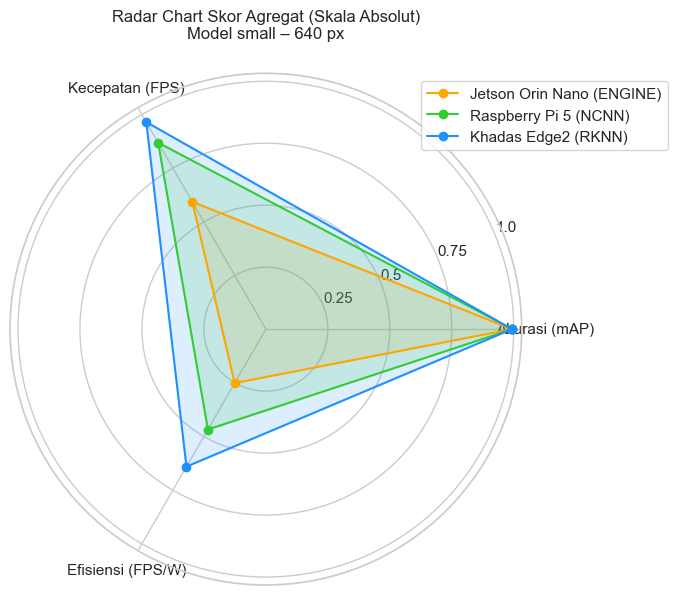

In [91]:
# --- 1. siapkan dataframe df (Platform, Backend, mAP, fps, power) persis seperti sebelumnya ---

df["Efficiency"] = df["fps"] / df["power"]

# 2. tetapkan batas absolut
ABS_RANGE = {
    "mAP"       : (0.0, 1.0),   # sudah dalam 0–1
    "fps"       : (0.0, 30.0),  # asumsikan 30 fps target
    "Efficiency": (0.0, 6.0),   # konservatif; ubah jika perlu
}

metrics = list(ABS_RANGE)

# 3. hitung skor (0–1) berdasar skala absolut
for m in metrics:
    lo, hi = ABS_RANGE[m]
    df[f"{m}_plot"] = (df[m] - lo) / (hi - lo)
    df[f"{m}_plot"] = df[f"{m}_plot"].clip(0, 1)      # batasi 0–1

# 4. radar chart (sama seperti sebelumnya, tapi pakai *_plot)
labels = ["Akurasi (mAP)", "Kecepatan (FPS)", "Efisiensi (FPS/W)"]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7,7), subplot_kw={"polar":True})
palette = {"Jetson Orin Nano":"#FFA500", "Khadas Edge2":"#1E90FF", "Raspberry Pi 5":"#32CD32"}

for _, r in df.iterrows():
    vals = [r[f"{m}_plot"] for m in metrics] + [r[f"{m}_plot"] for m in metrics[:1]]
    ax.plot(angles, vals, "-o", color=palette[r["Platform"]],
            label=f"{r['Platform']} ({r['Backend']})")
    ax.fill(angles, vals, color=palette[r["Platform"]], alpha=0.15)

ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels, fontsize=11)
ax.set_yticks([0.25,0.5,0.75,1.0]); ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
ax.set_title("Radar Chart Skor Agregat (Skala Absolut)\nModel small – 640 px", pad=25)
ax.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.tight_layout(); plt.show()


Saved: radar_s_320_absolute.png


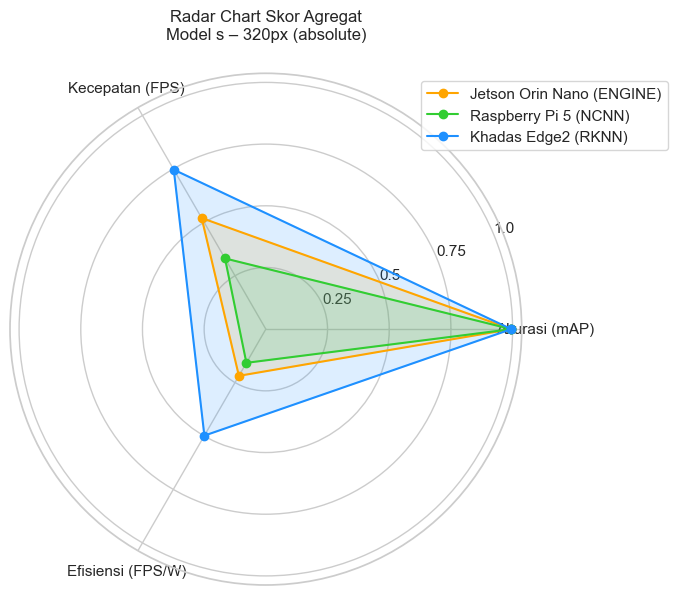

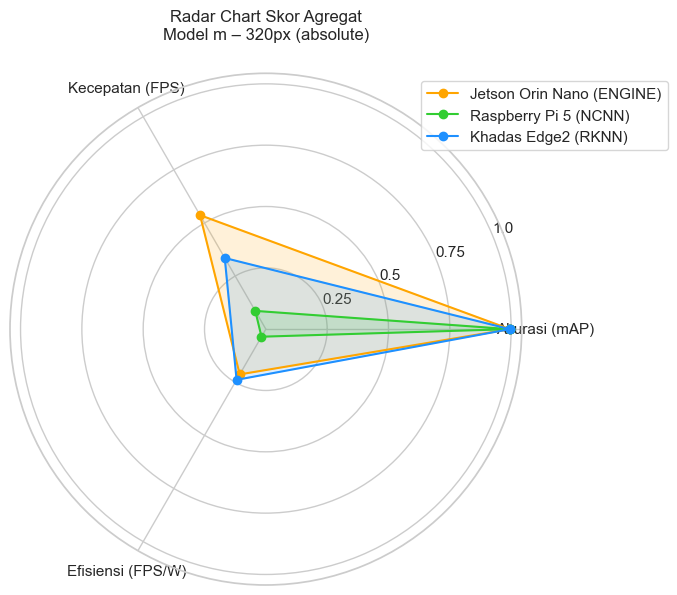

Saved: radar_n_640_absolute.png


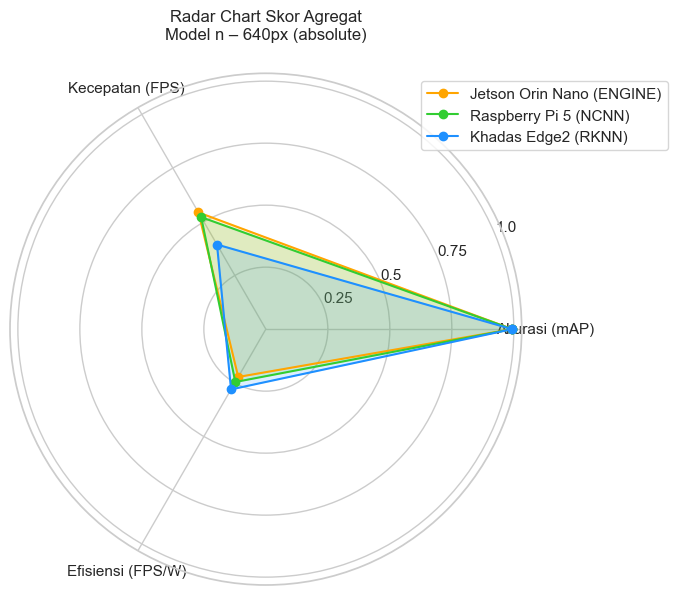

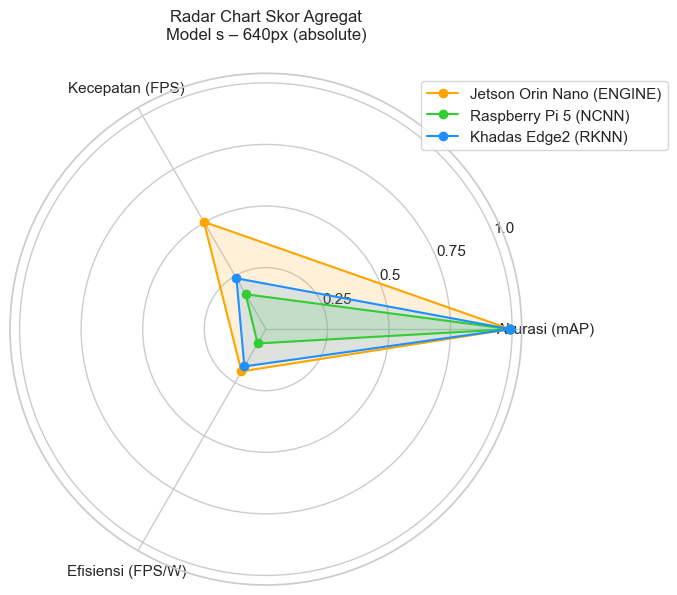

Saved: radar_m_640_absolute.png


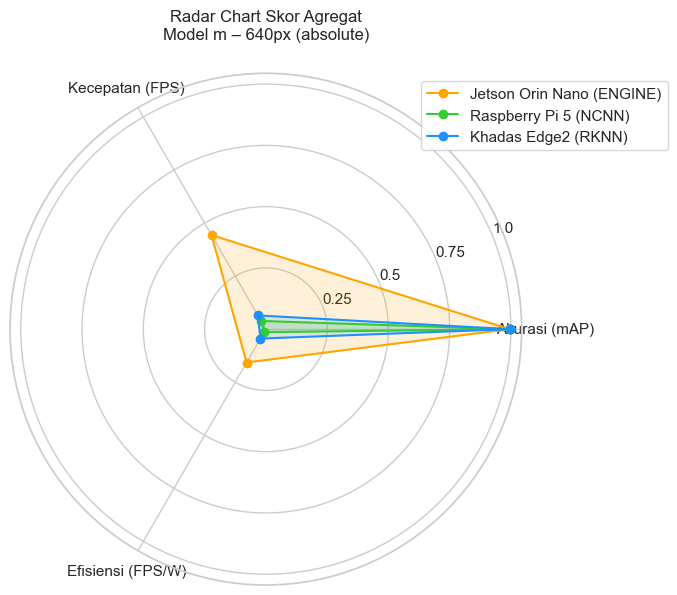

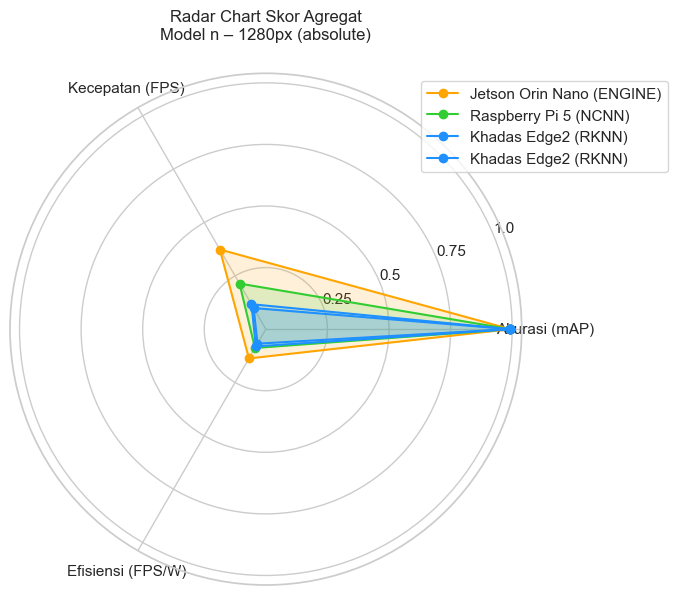

Saved: radar_s_1280_absolute.png


Saved: radar_m_1280_absolute.png


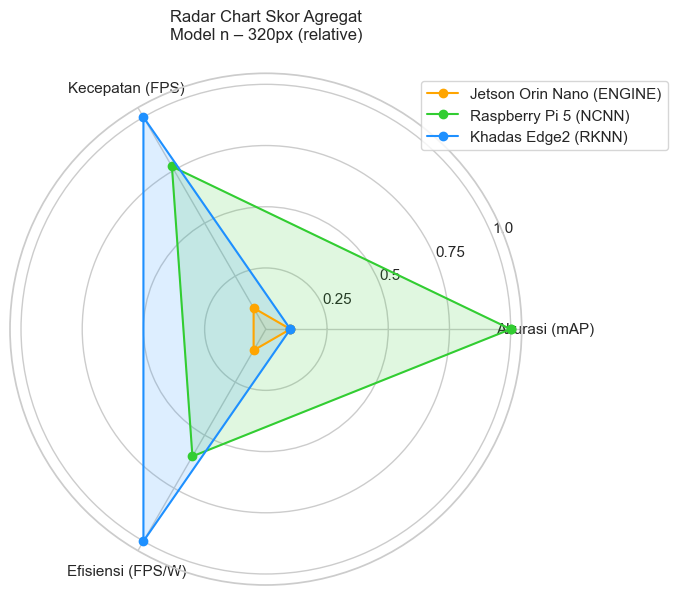

Saved: radar_s_320_relative.png


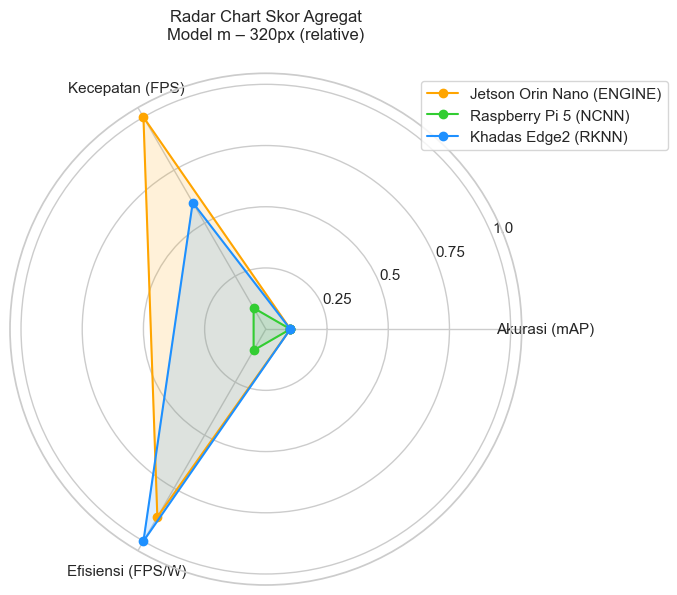

Saved: radar_n_640_relative.png


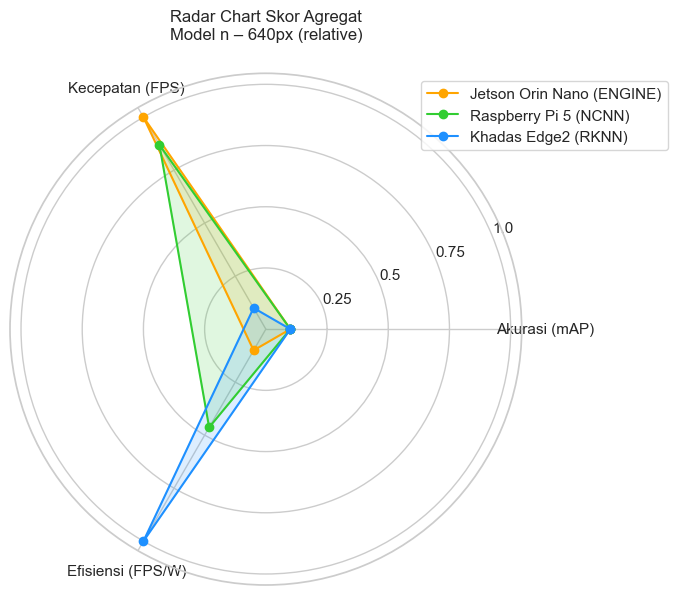

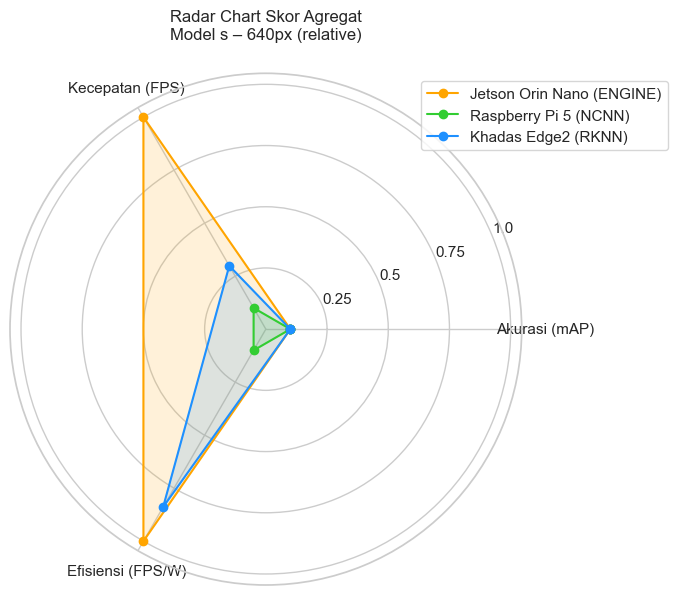

Saved: radar_m_640_relative.png


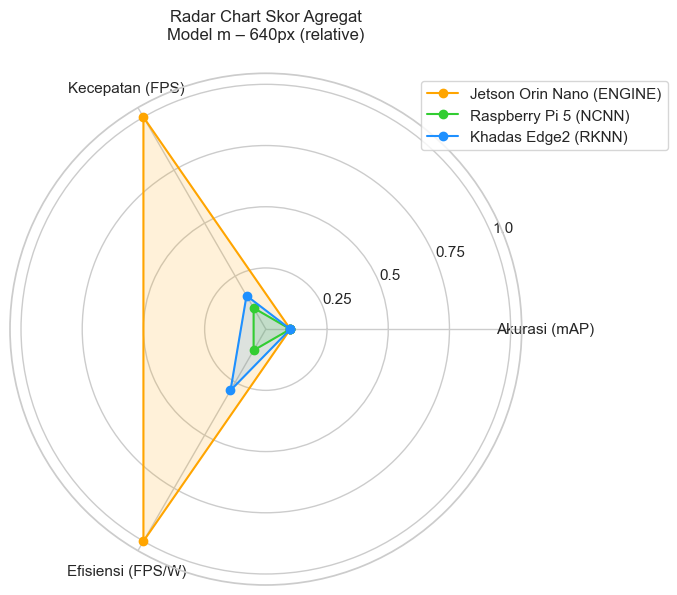

Saved: radar_s_1280_relative.png


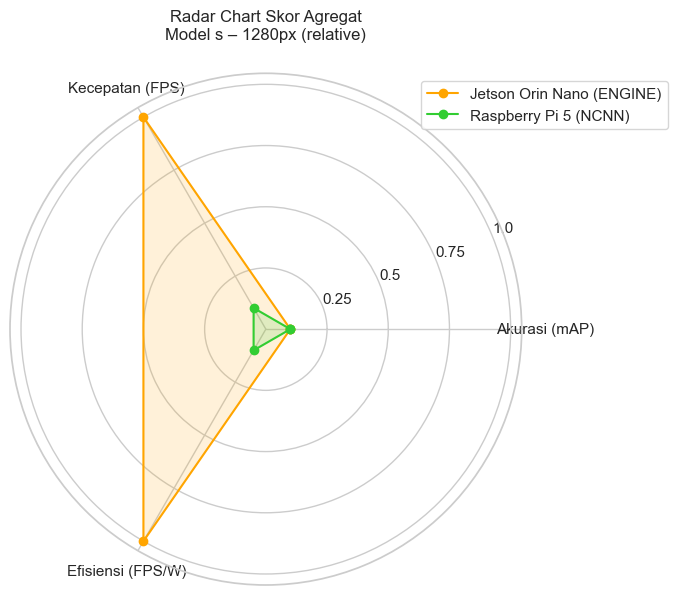

Saved: radar_m_1280_relative.png


Platform Backend  mAP   fps  Efficiency
0  Jetson Orin Nano  ENGINE  1.0  7.20        0.35
2    Raspberry Pi 5    NCNN  1.0  0.39        0.03
3      Khadas Edge2    RKNN  1.0  0.94        0.12

In [96]:
# === Radar Chart Skor Agregat per SBC — fungsi fleksibel ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

VAL = pd.read_excel(Path("hasil_validasi_terstandar.xlsx"))
PRED = pd.read_excel(Path("hasil_prediksi_terstandar.xlsx"))

def parse(row):
    p = row["model"].split("_")
    return pd.Series({
        "Platform"  : {"jetsonorin":"Jetson Orin Nano",
                       "khadasedge2":"Khadas Edge2",
                       "raspberrypi5":"Raspberry Pi 5"}.get(p[3], p[3]),
        "BackendRaw": row["format"],
        "Size"      : p[0][-1],             # n / s / m
        "Res"       : int(p[2]),            # 320 / 640 / 1280
    })

for df in (VAL, PRED):
    df[['Platform','BackendRaw','Size','Res']] = df.apply(parse, axis=1)

clean = lambda x: str(x).upper().replace("_FP16","").replace("_FP32","").replace("_INT8","").strip()
VAL["Backend"]  = VAL["BackendRaw"].apply(clean)
PRED["Backend"] = PRED["BackendRaw"].apply(clean)

map_col = next(c for c in VAL.columns if "map" in c.lower() and "50" in c.lower())

def radar(model_size='n', resolution=320,
          scale='absolute', save_png=False):
    """Plot radar-chart utk size (n/s/m) & resolusi tertentu.
       scale: 'relative' | 'absolute'."""
    
    # --- gabung mAP, FPS, power ---
    mask = (VAL["Size"]==model_size) & (VAL["Res"]==resolution)
    val  = VAL.loc[mask, ["Platform","Backend", map_col]].rename(columns={map_col:"mAP"})
    pred = PRED.loc[mask, ["Platform","Backend","fps","power"]]
    df   = val.merge(pred, on=["Platform","Backend"])
    
    # mode unggulan default (bisa diubah)
    target = {("Jetson Orin Nano","ENGINE"),
              ("Khadas Edge2","RKNN"),
              ("Raspberry Pi 5","NCNN")}
    df = df[df.apply(lambda r: (r["Platform"],r["Backend"]) in target, axis=1)]
    if df.empty:
        print("Kombinasi tidak ditemukan."); return
    
    df["Efficiency"] = df["fps"] / df["power"]
    metrics = ["mAP","fps","Efficiency"]
    
    # --- normalisasi ---
    if scale=="relative":
        for m in metrics:
            rng = df[m].max()-df[m].min()
            df[f"{m}_plot"] = 0.1 + 0.9*(df[m]-df[m].min())/(rng or 1)
    else:  # absolute
        ABS = {"mAP":(0,1), "fps":(0,30), "Efficiency":(0,6)}
        for m in metrics:
            lo, hi = ABS[m]
            df[f"{m}_plot"] = (df[m]-lo)/(hi-lo)
            df[f"{m}_plot"] = df[f"{m}_plot"].clip(0,1)
    
    # --- radar chart ---
    labels = ["Akurasi (mAP)","Kecepatan (FPS)","Efisiensi (FPS/W)"]
    ang = np.linspace(0,2*np.pi,len(labels),endpoint=False).tolist()+[0]
    pal = {"Jetson Orin Nano":"#FFA500","Khadas Edge2":"#1E90FF","Raspberry Pi 5":"#32CD32"}
    
    fig=plt.figure(figsize=(7,7)); ax=plt.subplot(111,polar=True)
    for _,r in df.iterrows():
        vals=[r[f"{m}_plot"] for m in metrics]+[r[f"{m}_plot"] for m in metrics[:1]]
        ax.plot(ang, vals,"-o",color=pal[r["Platform"]],
                label=f"{r['Platform']} ({r['Backend']})")
        ax.fill(ang, vals, color=pal[r["Platform"]], alpha=0.15)
    ax.set_xticks(ang[:-1]); ax.set_xticklabels(labels,fontsize=11)
    ax.set_yticks([0.25,0.5,0.75,1]); ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
    ax.set_title(f"Radar Chart Skor Agregat\nModel {model_size} – {resolution}px ({scale})", pad=25)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3,1))
    plt.tight_layout()
    if save_png:
        fname=f"radar_{model_size}_{resolution}_{scale}.png"
        fig.savefig(fname,dpi=300,bbox_inches="tight"); print("Saved:",fname)
    plt.show()
    return df[["Platform","Backend","mAP","fps","Efficiency"]].round(2)

# ==== Contoh penggunaan ====
radar('n', 320, scale='absolute')
radar('s', 320, scale='absolute', save_png=True)
radar('m', 320, scale='absolute')
radar('n', 640, scale='absolute', save_png=True)
radar('s', 640, scale='absolute')
radar('m', 640, scale='absolute', save_png=True)
radar('n', 1280, scale='absolute')
radar('s', 1280, scale='absolute', save_png=True)
radar('m', 1280, scale='absolute', save_png=True)

radar('n', 320, scale='relative')
radar('s', 320, scale='relative', save_png=True)
radar('m', 320, scale='relative')
radar('n', 640, scale='relative', save_png=True)
radar('s', 640, scale='relative')
radar('m', 640, scale='relative', save_png=True)
radar('n', 1280, scale='relative')
radar('s', 1280, scale='relative', save_png=True)
radar('m', 1280, scale='relative', save_png=True)

